# Network anomaly detection

Using network data build a multiclass classification model to predict anomolies

- Jan 2021
- Domino Valdano and Frank McQuillan


## Index

### Setup 

* <a href="#dependencies">Dependencies</a>
* <a href="#package_options">Package Options</a>
* <a href="#database_connection">Database Connection</a>
    
    
### Data Loading

* <a href="#external_table">External Table Definition</a>
* <a href="#download_data">Download Data and View Sample</a>


### Data Audit

* <a href="#summary_statistics">Summary Statistics</a>


### Data Exploration

* <a href="#de_categorical">Categorical Columns</a>
* <a href="#de_continuous">Continuous Columns</a>


### Feature Engineering

* <a href="#fe_continuous">Continuous Features</a>
* <a href="#fe_one_hot">One Hot Encode Categorical Features</a>
* <a href="#fe_combine">Combine Continuous & Categorical Features</a>
* <a href="#fe_cats_dep">Plot Categorical Features By Response</a>
* <a href="#fe_chi_sq">Chi-squared Testing</a>
* <a href="#fe_corr">Correlation Testing</a>
* <a href="#fe_scatter">Scatter Plots</a>


### Model Development

* <a href="#train_vali_split">Training & Validation Sample Split</a>


* **Random Forest (MADlib)**
    * <a href="#rf_train_model">Train model</a>
    * <a href="#rf_variable_importance">Variable Importance</a>
    * <a href="#rf_score_out_of_sample">Score Validation Data</a>
    * <a href="#rf_auc">Area Under ROC Curve</a>
    * <a href="#rf_roc">Receiver Operating Characteristic Graph (ROC Curve)</a>
    * <a href="#rf_confusion_matrix">Confusion Matrix</a>
    * <a href="#rf_model_storage">Model Storage</a>

### Model Scoring


* <a href="#model_scoring_Example">Model Scoring Example</a>

----


----
## Setup

<a id="dependencies"></a>

In [1]:
%load_ext sql

In [4]:
# Greenplum Database 5.x on GCP (PM demo machine) - via tunnel
%sql postgresql://gpadmin@localhost:8000/madlib
        
# PostgreSQL local
#%sql postgresql://fmcquillan@localhost:5432/madlib

u'Connected: gpadmin@madlib'

In [8]:
# dependencies
import psycopg2               # Python-PostgreSQL Database Adapter - https://pypi.python.org/pypi/psycopg2
import pandas as pd           # Python Data Analysis Library - https://pandas.pydata.org/
import seaborn as sns         # Statistical data visualization - https://seaborn.pydata.org/
import math                   # Mathematical functions - https://docs.python.org/2/library/math.html
import textwrap as tw         # Text wrapping and filling - https://docs.python.org/2/library/textwrap.html
import ipywidgets as widgets  # Jupyter Widgets - https://ipywidgets.readthedocs.io/en/latest/
import IPython.display as ipd # http://ipython.org/documentation.html

<a id="package_options"></a>

In [9]:
# package options
# %matplotlib inline
%pylab inline

pylab.rcParams['figure.figsize'] = (12, 8)
    
pd.options.mode.chained_assignment = None 
pd.set_option('display.max_colwidth', -1)

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000

sns.set(style="darkgrid")

Populating the interactive namespace from numpy and matplotlib


<a id="database_connection"></a>

In [10]:
# init to default values
database_host = 'localhost'
database_databasename = 'madlib'
database_username = 'gpadmin'
database_password = ''
database_port = '8000'

# interpret string as markdown
def printmd(string):
    ipd.display(ipd.Markdown(string))
    
# forms
message = "### Connection Details \n ------"
printmd(message)
    
printmd("**Host:**")
inputHost = widgets.Text()
ipd.display(inputHost)

printmd("**Port:**")
inputPort = widgets.Text()
ipd.display(inputPort)

printmd("**Database Name:**")
inputDatabaseName = widgets.Text()
ipd.display(inputDatabaseName)

printmd("**Username:**")
inputUsername = widgets.Text()
ipd.display(inputUsername)

printmd("**Password:**")
inputPassword = widgets.Text()
ipd.display(inputPassword)

printmd("*Leave blank for default values*")


def db_connect():
    global conn, cur
    try:
        connString = "host='{}' dbname='{}' user='{}' password='{}' port={}".format(database_host,database_databasename,database_username,database_password,database_port)
        # print connString
        conn = psycopg2.connect(connString)
        cur = conn.cursor()
        conn.autocommit = True
        message = "<span style='color:green'>**Connection successful!**</span>"
        printmd(message)
    except:
        message = "<span style='color:red'>**ERROR: Unable to connect to the database**</span>"
        printmd(message)
    
def on_button_click(b):
    
    global database_host, database_databasename, database_username, database_password, database_port
    
    ipd.clear_output()
    
    message = "### Connection Details \n ------"
    printmd(message)
    
    if inputHost.value == "":
        message = "**Host:** {} (default)".format(database_host)
        printmd(message)
    else:
        database_host = inputHost.value
        message = "**Host:** {}".format(database_host)
        printmd(message)

    if inputPort.value == "":
        message = "**Port:** {} (default)".format(database_port)
        printmd(message)
    else:
        database_port = inputPort.value
        message = "**Port:** {}".format(database_port)
        printmd(message)
        
    if inputDatabaseName.value == "":
        message = "**Database name:** {} (default)".format(database_databasename)
        printmd(message)
    else:
        database_databasename = inputDatabaseName.value
        message = "**Database name:** {}".format(database_databasename)
        printmd(message)
        
    if inputUsername.value == "":
        message = "**Username:** {} (default)".format(database_username)
        printmd(message)
    else:
        database_username = inputUsername.value
        message = "**Username:** {}".format(database_username)
        printmd(message)
        
    if inputPassword.value == "":
        message = "**Password:** {} (default)".format(database_password)
        printmd(message)
    else:
        database_password = inputPassword.value
        message = "**Password:** ###########"
        printmd(message)
    
    printmd("------")
    db_connect()
        
button = widgets.Button(description="Connect")
ipd.display(button)
button.on_click(on_button_click)

### Connection Details 
 ------

**Host:**

Text(value=u'')

**Port:**

Text(value=u'')

**Database Name:**

Text(value=u'')

**Username:**

Text(value=u'')

**Password:**

Text(value=u'')

*Leave blank for default values*

Button(description=u'Connect', style=ButtonStyle())

In [11]:
# helper function
def query_gpdb(query): 

    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    return pd.DataFrame(cur.fetchall(), columns=colnames)

----
## Data Loading

Training data

In [14]:
%%sql
DROP TABLE IF EXISTS training_data;
CREATE TABLE training_data (
    a1 TEXT,
    a2 TEXT,
    a3 TEXT,
    a4 FLOAT,
    a5 FLOAT,
    a6 INTEGER,
    a7 INTEGER,
    a8 INTEGER,
    a9 INTEGER,
    a10 INTEGER,
    a11 INTEGER,
    a12 FLOAT,
    a13 FLOAT,
    a14 FLOAT,
    a15 INTEGER,
    a16 FLOAT,
    a17 FLOAT,
    a18 FLOAT,
    a19 FLOAT,
    a20 FLOAT,
    a21 FLOAT,
    a22 FLOAT,
    a23 FLOAT,
    a24 INTEGER,
    a25 FLOAT,
    a26 FLOAT,
    a27 FLOAT,
    a28 FLOAT,
    a29 FLOAT,
    a30 FLOAT,
    a31 FLOAT,
    a32 FLOAT,
    a33 FLOAT,
    a34 FLOAT,
    a35 FLOAT,
    a36 FLOAT,
    a37 FLOAT,
    a38 FLOAT,
    a39 FLOAT,
    a40 FLOAT,
    a41 FLOAT,
    a42 INTEGER,
    y TEXT
);

COPY training_data FROM '/home/gpadmin/network_data/training.csv' CSV DELIMITER ',';

Done.
Done.
4898431 rows affected.


[]

In [12]:
%%sql
SELECT * FROM training_data LIMIT 5;

 * postgresql://gpadmin@localhost:8000/madlib
5 rows affected.


a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25,a26,a27,a28,a29,a30,a31,a32,a33,a34,a35,a36,a37,a38,a39,a40,a41,a42,y
ICMP,ECR_I,STAT10,1032.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,1201.0,1.0,0.0,0.0,511.0,0.0,0.0,255.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0,class18
ICMP,ECR_I,STAT10,1032.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,447.0,1.0,0.0,0.0,511.0,0.0,0.0,255.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0,class18
TCP,PRIVATE,STAT02,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.15,0,809.0,0.0,0.0,0.07,18.0,0.0,1.0,18.0,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.07,0.0,255.0,0.0,0.0,0.06,0.0,123.0,0.0,0,class10
TCP,PRIVATE,STAT06,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.09,0,13.0,0.0,0.0,0.05,24.0,0.0,0.0,24.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.09,0.0,255.0,0.0,0.0,0.04,1.0,280.0,1.0,0,class10
TCP,HTTP,STAT10,319.0,421.0,0,0,0,0,1,0,0.0,0.67,1.0,0,19.0,1.0,0.0,0.0,3.0,0.0,0.0,255.0,0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,normal


In [13]:
%%sql
SELECT COUNT(*) FROM training_data;

 * postgresql://gpadmin@localhost:8000/madlib
1 rows affected.


count
4898431


Eval data

In [16]:
%%sql
DROP TABLE IF EXISTS eval_data;
CREATE TABLE eval_data (
    id INTEGER,
    a1 TEXT,
    a2 TEXT,
    a3 TEXT,
    a4 FLOAT,
    a5 FLOAT,
    a6 INTEGER,
    a7 INTEGER,
    a8 INTEGER,
    a9 INTEGER,
    a10 INTEGER,
    a11 INTEGER,
    a12 FLOAT,
    a13 FLOAT,
    a14 FLOAT,
    a15 INTEGER,
    a16 FLOAT,
    a17 FLOAT,
    a18 FLOAT,
    a19 FLOAT,
    a20 FLOAT,
    a21 FLOAT,
    a22 FLOAT,
    a23 FLOAT,
    a24 INTEGER,
    a25 FLOAT,
    a26 FLOAT,
    a27 FLOAT,
    a28 FLOAT,
    a29 FLOAT,
    a30 FLOAT,
    a31 FLOAT,
    a32 FLOAT,
    a33 FLOAT,
    a34 FLOAT,
    a35 FLOAT,
    a36 FLOAT,
    a37 FLOAT,
    a38 FLOAT,
    a39 FLOAT,
    a40 FLOAT,
    a41 FLOAT,
    a42 INTEGER
);

COPY eval_data FROM '/home/gpadmin/network_data/eval-rev2-1.csv' DELIMITER ',' CSV HEADER;

Done.
Done.
311030 rows affected.


[]

In [14]:
%%sql
SELECT * FROM eval_data ORDER BY id LIMIT 10;

 * postgresql://gpadmin@localhost:8000/madlib
10 rows affected.


id,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25,a26,a27,a28,a29,a30,a31,a32,a33,a34,a35,a36,a37,a38,a39,a40,a41,a42
0,ICMP,ECR_I,STAT10,1032.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,1328.0,1.0,0.0,0.0,511.0,0.0,0.0,255.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0
1,TCP,HTTP,STAT10,280.0,3413.0,0,0,0,0,1,0,0.0,0.0,1.0,0,674.0,0.04,0.0,0.0,26.0,0.0,0.0,251.0,0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0,1.0,0.0,26.0,0.0,0.0,0.0,0.0,26.0,0.0,0
2,TCP,HTTP,STAT10,218.0,1493.0,0,0,0,0,1,0,0.0,0.0,1.0,0,990.0,0.01,0.0,0.0,9.0,0.0,0.0,255.0,0,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,1.0,0.0,129.0,0.0,0.0,0.0,0.0,9.0,0.0,0
3,ICMP,ECR_I,STAT10,520.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,1178.0,1.0,0.0,0.0,511.0,0.0,0.0,255.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0
4,ICMP,ECR_I,STAT10,1032.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,1554.0,1.0,0.0,0.0,510.0,0.0,0.0,255.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,510.0,0.0,0
5,ICMP,ECR_I,STAT10,1032.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,1233.0,1.0,0.0,0.0,511.0,0.0,0.0,255.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0
6,UDP,PRIVATE,STAT10,42.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,1695.0,0.01,0.0,0.0,3.0,0.0,0.0,255.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,3.0,0.0,0
7,TCP,HTTP,STAT10,305.0,1846.0,0,0,0,0,1,0,0.0,0.4,1.0,0,1289.0,0.12,0.0,0.0,5.0,0.0,0.0,255.0,0,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0,0.0,0.0,0.0,4.0,0.0,0
8,ICMP,ECR_I,STAT10,1032.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,989.0,1.0,0.0,0.0,511.0,0.0,0.0,255.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0
9,ICMP,ECR_I,STAT10,520.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,766.0,1.0,0.0,0.0,476.0,0.0,0.0,255.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,476.0,0.0,0


In [15]:
%%sql
SELECT COUNT(*) FROM eval_data;

 * postgresql://gpadmin@localhost:8000/madlib
1 rows affected.


count
311030


<a id="external_table"></a>

----
## Data Audit

<a id="summary_statistics"></a>
Summary Statistics

https://madlib.apache.org/docs/latest/group__grp__summary.html

In [16]:
%%sql
DROP TABLE IF EXISTS training_summary;
SELECT * FROM madlib.summary( 'training_data',   -- Source table
                              'training_summary'    -- Output table
                            );

 * postgresql://gpadmin@localhost:8000/madlib
Done.
1 rows affected.


output_table,num_col_summarized,duration
training_summary,43,360.29794693


In [17]:
%%sql
SELECT * FROM training_summary;

 * postgresql://gpadmin@localhost:8000/madlib
43 rows affected.


group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,positive_values,negative_values,zero_values,mean,variance,confidence_interval,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
None,None,a1,1,text,4898431,3,0,0,0.0,0.0,None,None,None,None,None,None,3.0,4.0,None,None,None,"[u'ICMP', u'TCP', u'UDP']","[2833545L, 1870598L, 194288L]"
None,None,a2,2,text,4898431,70,0,0,0.0,0.0,None,None,None,None,None,None,3.0,11.0,None,None,None,"[u'ECR_I', u'PRIVATE', u'HTTP', u'SMTP', u'OTHER', u'DOMAIN_U', u'FTP_DATA', u'ECO_I', u'FINGER', u'URP_I']","[2811660L, 1100745L, 623078L, 96530L, 72647L, 57782L, 40689L, 16338L, 6904L, 5378L]"
None,None,a3,3,text,4898431,11,0,0,0.0,0.0,None,None,None,None,None,None,6.0,6.0,None,None,None,"[u'STAT10', u'STAT06', u'STAT02', u'STAT05', u'STAT03', u'STAT11', u'STAT07', u'STAT08', u'STAT04', u'STAT01']","[3744328L, 840347L, 297625L, 8094L, 6075L, 1040L, 532L, 161L, 122L, 57L]"
None,None,a4,4,float8,4898431,7195,0,None,0.0,None,3745885,0,1152546,1832.10418316,8.86292473314e+11,"[998.392083442931, 2665.81628286865]",0.0,1379963888.0,45.0,520.0,1032.0,"[u'1032', u'0', u'520', u'105', u'147', u'146', u'42', u'8', u'44', u'145']","[2255724L, 1152559L, 545377L, 73912L, 27348L, 20378L, 10755L, 10529L, 9236L, 9224L]"
None,None,a5,5,float8,4898431,22788,0,None,0.0,None,833577,0,4064854,1093.62281371,4.1604091068e+11,"[522.41308836093, 1664.83253906548]",0.0,1309937401.0,0.0,0.0,0.0,"[u'0', u'105', u'147', u'146', u'145', u'42', u'330', u'329', u'331', u'332']","[4065027L, 44906L, 25045L, 22935L, 9632L, 9410L, 8425L, 7908L, 7886L, 7415L]"
None,None,a6,6,int4,4898431,2,0,None,0.0,None,4091,0,4894340,0.000835165382548,0.000834468051686,"[0.000809583504108748, 0.00086074726098726]",0.0,1.0,0.0,0.0,0.0,"[u'0', u'1']","[4894340L, 4091L]"
None,None,a7,7,int4,4898431,2,0,None,0.0,None,2,0,4898429,4.08294002712e-07,4.0829391936e-07,"[-1.57572557277603e-07, 9.74160562702197e-07]",0.0,1.0,0.0,0.0,0.0,"[u'0', u'1']","[4898429L, 2L]"
None,None,a8,8,int4,4898431,3,0,None,0.0,None,110,0,4898321,3.67464602441e-05,6.53257034677e-05,"[2.95888240326134e-05, 4.39040964556e-05]",0.0,2.0,0.0,0.0,0.0,"[u'0', u'2', u'1']","[4898321L, 70L, 40L]"
None,None,a9,9,int4,4898431,2,0,None,0.0,None,334,0,4898097,6.8185098453e-05,6.81804631641e-05,"[6.08727387362456e-05, 7.54974581696616e-05]",0.0,1.0,0.0,0.0,0.0,"[u'0', u'1']","[4898097L, 334L]"
None,None,a10,10,int4,4898431,2,0,None,0.0,None,703067,0,4195364,0.143529019802,0.122928465372,"[0.143218525379488, 0.143839514225438]",0.0,1.0,0.0,0.0,0.0,"[u'0', u'1']","[4195364L, 703067L]"


In [18]:
%%sql
DROP TABLE IF EXISTS eval_summary;
SELECT * FROM madlib.summary( 'eval_data',   -- Source table
                              'eval_summary'    -- Output table
                            );

 * postgresql://gpadmin@localhost:8000/madlib
Done.
1 rows affected.


output_table,num_col_summarized,duration
eval_summary,43,14.0963158607


In [ ]:
%%sql
SELECT * FROM eval_summary;

----
## Data Exploration

<a id="de_categorical"></a>
#### Categorical Columns

-----
 **Select Column:**

RHJvcGRvd24oZGVzY3JpcHRpb249dSdDb2x1bW46JywgaW5kZXg9NCwgb3B0aW9ucz0oJ2ExJywgJ2EyJywgJ2EzJywgJ2E2JywgJ2E3JywgJ2E4JywgJ2E5JywgJ2ExMCcsICdhMTEnLCAnYTHigKY=


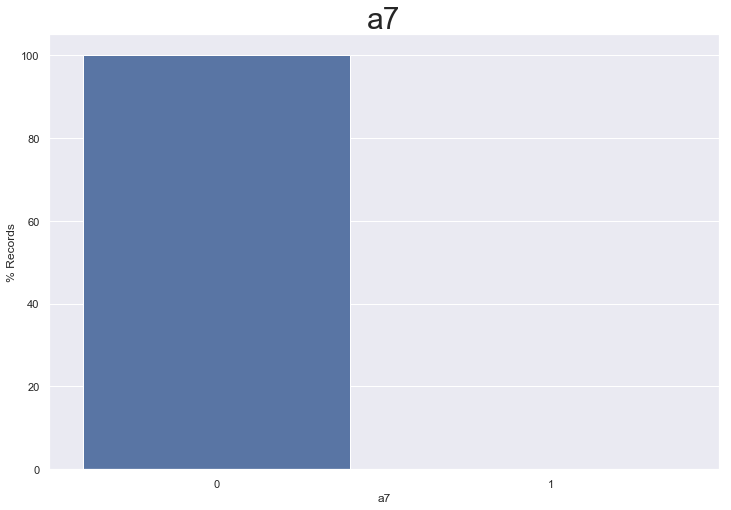

In [18]:
catColumns = ['a1','a2','a3', 'a6','a7','a8', 'a9',
              'a10','a11', 'a15','a24','a42',
              'y']

def bar_plot(data,title,x,xLabel,y,yLabel,color=None,xAxisRotation=90):

    # Bar plot
    pylab.rcParams['figure.figsize'] = (12, 8)
    seq_col_brew = sns.color_palette("Blues_r", 1)
    sns.color_palette(seq_col_brew)
    if color != None:
        plt = sns.barplot(x=x, y=y, data=data, color=color)
    else:
        plt = sns.barplot(x=x, y=y, data=data)
        
    # titles
    plt.set_title(title,fontsize=30)
    plt.set_xlabel(xLabel,fontsize=12)
    plt.set_ylabel(yLabel,fontsize=12)
    
    # rotate x axis labels
    for item in plt.get_xticklabels():
        item.set_rotation(xAxisRotation)

    # remove scientific notation
    plt.ticklabel_format(style='plain', axis='y')


def get_cat_data_frame(col):
    query = """
        SELECT *
              ,round((record_count * 100.0) / sum(record_count) OVER(),2) AS perc_records
        FROM (
            SELECT {} AS col
                  ,count(*) AS record_count
            FROM training_data
            GROUP BY 1
        ) foo
        ORDER BY perc_records DESC
    """.format(col)
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    return pd.DataFrame(cur.fetchall(), columns=colnames)
    
def on_cat_selection(res):
    if res['type'] == 'change' and res['name'] == 'value':
        ipd.clear_output()
        printmd("-----\n **Select Column:**")
        ipd.display(catDropdown)
        df = get_cat_data_frame(res['new'])
        bar_plot(df,res['new'],"col",res['new'],"perc_records","% Records", None, 0)
    
catDropdown = widgets.Dropdown(
    options=catColumns,
    value=catColumns[0],
    description='Column:',
    disabled=False,
)

catDropdown.observe(on_cat_selection)
printmd("-----\n **Select Column:**")
ipd.display(catDropdown)
df = get_cat_data_frame(catColumns[0])
bar_plot(df,catColumns[0],"col",catColumns[0],"perc_records","% Records", None, 0)

* Low % of values in any one class can skew model results and/or create unstable model. In practice we may consider merging and/or excluding some groups. (e.g. a4: [i], a5: [gg], a7: [z,j,dd,n,o), a13: [s,p])

<a id="de_continuous"></a>
#### Continuous Columns

-----


SEJveChjaGlsZHJlbj0oRHJvcGRvd24oZGVzY3JpcHRpb249dSdDb2x1bW46JywgaW5kZXg9Nywgb3B0aW9ucz0oJ2E0JywgJ2E1JywgJ2ExMicsICdhMTMnLCAnYTE0JywgJ2ExNicsICdhMTfigKY=


-----


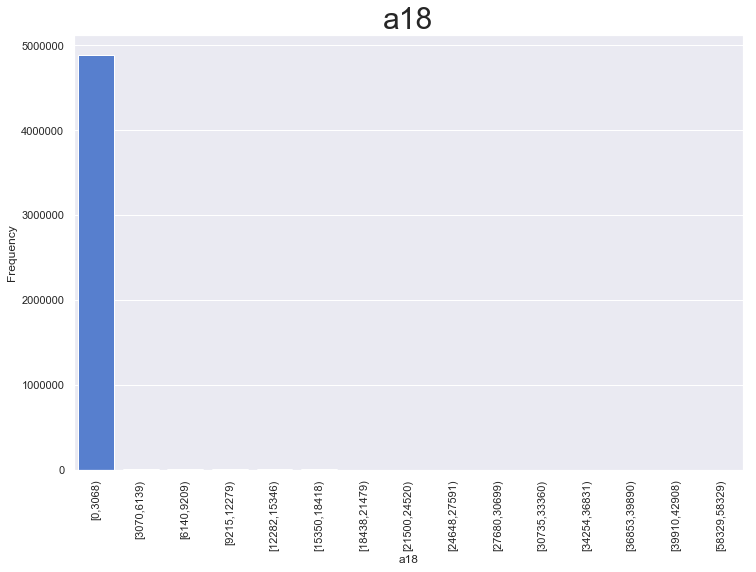

In [19]:
contColumns = ['a4', 'a5','a12', 'a13', 'a14', 'a16', 
               'a17', 'a18', 'a19', 'a20', 'a21', 
               'a22', 'a23', 'a25', 'a26', 'a27', 
               'a28', 'a29', 'a30', 'a31', 'a32', 
               'a33', 'a34', 'a35', 'a36', 'a37', 
               'a38', 'a39', 'a40', 'a41']
sliderValue = 20
colName = contColumns[0]

def get_cont_data_frame(col, buckets):
    query = """
        WITH aggs AS (
            SELECT min({c}) AS min,
                   max({c}) AS max
              FROM training_data
        )
        SELECT width_bucket({c}, min, max, {b}-1) AS bucket,
               ('[' || min({c}) || ',' || max({c}) || ')')::text as range,
               count(*) as freq
        FROM training_data, aggs
        GROUP BY bucket
        ORDER BY bucket
    """.format(c=col, b=buckets)
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    return pd.DataFrame(cur.fetchall(), columns=colnames)
    
def graph_reset():
    ipd.clear_output()
    printmd("-----\n")
    ipd.display(widgets.HBox((contDropdown,bucketsSlider)))
    printmd("-----\n")
    df = get_cont_data_frame(colName,sliderValue)
    bar_plot(df,colName,"range",colName,"freq","Frequency", "#4378E2")    
    
def on_cont_selection(res):
    global colName
    if res['type'] == 'change' and res['name'] == 'value':
        colName = res['new']
        graph_reset()
        
def on_slider_selection(res):
    global sliderValue
    if res['new'] == {} and res['old']:
        sliderValue = res['old']['value']
        graph_reset()
    
# Look at log transforms
#colsAddLogs = contColumns + ["log({} + 1)".format(c) for c in contColumns]
colsAddLogs = contColumns

contDropdown = widgets.Dropdown(
    options=colsAddLogs,
    value=colsAddLogs[0],
    description='Column:',
    disabled=False,
)

bucketsSlider = widgets.IntSlider(
    value=sliderValue,
    min=5,
    max=50,
    step=1,
    description='# Buckets:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

contDropdown.observe(on_cont_selection)
bucketsSlider.observe(on_slider_selection)

graph_reset()



* a15 large number of outliers - consider correcting
* Consider variable transformation if test non-tree based algorithm
* Histogram values are being calculated in the database - minimal data movement back to client

### Clustering

In [22]:
%%sql
DROP TABLE IF EXISTS training_data_encoded, training_data_encoded_dictionary;
SELECT madlib.encode_categorical_variables (
        'training_data',            -- Source table
        'training_data_encoded',      -- Output table
        'a1, a2, a3'                        -- Categorical columns
        );

Done.
1 rows affected.


encode_categorical_variables
""


In [23]:
%%sql
select * from training_data_encoded limit 5;

5 rows affected.


a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25,a26,a27,a28,a29,a30,a31,a32,a33,a34,a35,a36,a37,a38,a39,a40,a41,a42,y,a1_ICMP,a1_TCP,a1_UDP,a2_AOL,a2_AUTH,a2_BGP,a2_COURIER,a2_CSNET_NS,a2_CTF,a2_DAYTIME,a2_DISCARD,a2_DOMAIN,a2_DOMAIN_U,a2_ECHO,a2_ECO_I,a2_ECR_I,a2_EFS,a2_EXEC,a2_FINGER,a2_FTP,a2_FTP_DATA,a2_GOPHER,a2_HARVEST,a2_HOSTNAMES,a2_HTTP,a2_HTTP_2784,a2_HTTP_443,a2_HTTP_8001,a2_IMAP4,a2_IRC,a2_ISO_TSAP,a2_KLOGIN,a2_KSHELL,a2_LDAP,a2_LINK,a2_LOGIN,a2_MTP,a2_NAME,a2_NETBIOS_DGM,a2_NETBIOS_NS,a2_NETBIOS_SSN,a2_NETSTAT,a2_NNSP,a2_NNTP,a2_NTP_U,a2_OTHER,a2_PM_DUMP,a2_POP_2,a2_POP_3,a2_PRINTER,a2_PRIVATE,a2_RED_I,a2_REMOTE_JOB,a2_RJE,a2_SHELL,a2_SMTP,a2_SQL_NET,a2_SSH,a2_SUNRPC,a2_SUPDUP,a2_SYSTAT,a2_TELNET,a2_TFTP_U,a2_TIME,a2_TIM_I,a2_URH_I,a2_URP_I,a2_UUCP,a2_UUCP_PATH,a2_VMNET,a2_WHOIS,a2_X11,a2_Z39_50,a3_STAT01,a3_STAT02,a3_STAT03,a3_STAT04,a3_STAT05,a3_STAT06,a3_STAT07,a3_STAT08,a3_STAT09,a3_STAT10,a3_STAT11
305.0,1496.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1779.0,0.33,0.0,0.0,3.0,0.0,0.0,255.0,0.0,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,normal,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06,0.0,924.0,0.0,0.0,0.07,13.0,0.0,0.0,13.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.05,0.0,255.0,0.0,0.0,0.06,1.0,223.0,1.0,0.0,class10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.0,1426.0,0.0,0.0,0.07,5.0,0.0,1.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.02,0.0,255.0,0.0,0.0,0.07,0.0,94.0,0.0,0.0,class10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
46.0,143.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,1.0,0.0,268.0,0.0,0.0,0.02,112.0,0.0,0.0,230.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9,0.0,255.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,normal,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1286.0,1.0,0.0,0.0,511.0,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0.0,class18,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


Sample training data

In [191]:
%%sql
drop table if exists training_data_work1;
create table training_data_work1 as
(select * from training_data_encoded where y='class19' 
                                            or y='class12'
                                            or y='class13');

Done.
9 rows affected.


[]

In [192]:
%%sql
drop table if exists training_data_work2, training_data_work2_summary;
select madlib.cols2vec('training_data_work1',
                       'training_data_work2',
                       '*',
                       'y',
                       'y'
                       );

Done.
1 rows affected.


cols2vec
""


In [193]:
%%sql
ALTER TABLE training_data_work2 ADD column pid serial;

Done.


[]

In [197]:
%%sql
DROP TABLE IF EXISTS training_data_work3;

CREATE TABLE training_data_work3 AS
(SELECT * FROM madlib.kmeanspp(
    'training_data_work2',                  -- points table
    'feature_vector',                      -- column name in point table
    3,
    'madlib.dist_norm1',   -- distance function
    'madlib.avg',                  -- aggregate function
    20,                            -- max iterations
    0.001                         -- minimum fraction of centroids reassigned to continue iterating
));

Done.
1 rows affected.


[]

In [198]:
%%sql
select * from training_data_work3;

1 rows affected.


centroids,cluster_variance,objective_fn,frac_reassigned,num_iterations
"[[174.5, 1193.5, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.5, 0.0, 1.0, 0.0, 1268.0, 0.0, 318.0, 0.02, 1.0, 0.0, 0.0, 47.5, 0.5, 0.22, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.185, 0.5, 255.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.315, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [265.666666666667, 2444.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 828.333333333333, 0.00333333333333333, 41.3333333333333, 0.03, 1.0, 0.0, 0.0, 1.66666666666667, 1.0, 0.0, 0.23, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0133333333333333, 0.0, 193.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [51.0, 8127.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.25, 1.0, 0.0, 1007.5, 0.0, 4.5, 0.0075, 1.25, 0.0, 0.125, 247.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9725, 1.0, 255.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]]","[1018.02, 1569.02666666667, 1902.835]",4489.88166667,0.0,4


In [199]:
%%sql
DROP TABLE IF EXISTS point_cluster_map;
CREATE TABLE point_cluster_map AS
SELECT data.*, (madlib.closest_column(centroids, feature_vector, 'madlib.squared_dist_norm2')).*
FROM training_data_work2 as data, training_data_work3;
ALTER TABLE point_cluster_map RENAME column_id to cluster_id; -- change column name
SELECT y, pid, cluster_id, distance FROM point_cluster_map ORDER BY cluster_id, distance desc;

Done.
9 rows affected.
Done.
9 rows affected.


y,pid,cluster_id,distance
class19,5,0,130415.00005
class19,6,0,130415.00005
class12,9,1,227188.498567
class12,7,1,143345.1646
class12,4,1,26055.3228333
class13,1,2,552866.328938
class13,8,2,499208.203638
class13,3,2,50854.2031875
class13,2,2,35591.7032875


In [200]:
%%sql
SELECT * FROM madlib.simple_silhouette( 'training_data_work2',          -- Input points table
                                              'feature_vector',              -- Points column in input table
                                              (select centroids from training_data_work3),           -- Column in centroids table containing centroids
                                              'madlib.squared_dist_norm2'   -- Distance function
                                      );

1 rows affected.


simple_silhouette
0.958060306293


In [201]:
%%sql
DROP TABLE IF EXISTS km_points_silh;
SELECT * FROM madlib.simple_silhouette_points( 'training_data_work2',          -- Input points table
                                              'km_points_silh',      -- Output table
                                              'pid',                 -- Point ID column in input table
                                              'feature_vector',              -- Points column in input table
                                              'training_data_work3',           -- Centroids table
                                              'centroids',           -- Column in centroids table containing centroids
                                              'madlib.squared_dist_norm2'   -- Distance function
                                      );
SELECT * FROM km_points_silh ORDER BY centroid_id;

Done.
1 rows affected.
9 rows affected.


pid,centroid_id,neighbor_centroid_id,silh
5,0,1,0.953041159487
6,0,1,0.88941721291
4,1,0,0.983233562677
9,1,0,0.897427669393
7,1,0,0.933980659807
3,2,1,0.998430958564
1,2,1,0.983379256517
8,2,1,0.984725987494
2,2,1,0.99890628979


whole table

In [188]:
%%sql
drop table if exists training_data_work10, training_data_work10_summary;
select madlib.cols2vec('training_data_encoded',
                       'training_data_work10',
                       '*',
                       'y',
                       'y'
                       );

Done.
1 rows affected.


cols2vec
""


In [202]:
%%sql
DROP TABLE IF EXISTS point_cluster_map;
CREATE TABLE point_cluster_map AS
SELECT data.*, (madlib.closest_column(centroids, feature_vector, 'madlib.squared_dist_norm2')).*
FROM training_data_work10 as data, training_data_work3;
ALTER TABLE point_cluster_map RENAME column_id to cluster_id; -- change column name

Done.
4898431 rows affected.
Done.


[]

In [203]:
%%sql
select * from point_cluster_map limit 5;

5 rows affected.


y,feature_vector,cluster_id,distance
class06,"[8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 516.0, 1.0, 0.0, 0.0, 22.0, 0.0, 0.0, 255.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",0,2226307.06225
class17,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1008.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.09, 0.91, 0.0, 0.0, 0.0, 1.0, 0.93, 0.0, 0.0, 0.0, 255.0, 0.0, 0.0, 1.0, 0.06, 407.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0,1790626.80735
class17,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1089.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.13, 0.87, 0.0, 0.0, 0.0, 0.0, 0.78, 1.0, 0.0, 0.0, 255.0, 0.0, 0.0, 1.0, 0.22, 509.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0,1848294.88565
class06,"[8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 854.0, 1.0, 0.0, 0.0, 19.0, 0.0, 0.0, 255.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",0,1832082.06225
class17,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 815.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.31, 0.69, 0.0, 0.0, 0.0, 1.0, 0.77, 0.0, 0.0, 0.0, 255.0, 0.0, 0.0, 1.0, 0.22, 509.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0,2021463.21935


In [208]:
%%sql 
select count(*) from point_cluster_map where cluster_id = 0 and distance < 130415.0;

1 rows affected.


count
22


In [147]:
%%sql
DROP TABLE IF EXISTS k_auto, k_auto_summary;

SELECT madlib.kmeanspp_auto(
    'training_data_work2',                  -- points table
    'k_auto',                      -- output table
    'feature_vector',                      -- column name in point table
    ARRAY[2,3,4],              -- k values to try
    'madlib.squared_dist_norm2',   -- distance function
    'madlib.avg',                  -- aggregate function
    20,                            -- max iterations
    0.001,                         -- minimum fraction of centroids reassigned to continue iterating
    1.0,                           -- centroid seed
    'silhouette'                         -- k selection algorithm (silhouette or elbow or both)
);

Done.
1 rows affected.


kmeanspp_auto
""


In [148]:
%%sql
SELECT * FROM k_auto_summary;

1 rows affected.


k,centroids,cluster_variance,objective_fn,frac_reassigned,num_iterations,silhouette,selection_algorithm
2,"[[51.0, 8127.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.25, 1.0, 0.0, 1007.5, 0.0, 4.5, 0.0075, 1.25, 0.0, 0.125, 247.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9725, 1.0, 255.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [229.2, 1943.8, 0.0, 0.0, 0.2, 0.6, 0.8, 0.0, 1.4, 0.0, 1.0, 0.0, 1004.2, 0.002, 152.0, 0.026, 1.0, 0.0, 0.0, 20.0, 0.8, 0.088, 0.138, 0.0, 1.2, 0.0, 0.0, 0.0, 0.0, 0.082, 0.2, 217.8, 0.0, 0.0, 0.0, 0.0, 1.0, 0.126, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]]","[1138520.43905, 2874858.19556]",4013378.63461,0.0,2,0.988866700962,silhouette


In [149]:
%%sql
SELECT * FROM k_auto ORDER BY k;

3 rows affected.


k,centroids,cluster_variance,objective_fn,frac_reassigned,num_iterations,silhouette
2,"[[51.0, 8127.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.25, 1.0, 0.0, 1007.5, 0.0, 4.5, 0.0075, 1.25, 0.0, 0.125, 247.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9725, 1.0, 255.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [229.2, 1943.8, 0.0, 0.0, 0.2, 0.6, 0.8, 0.0, 1.4, 0.0, 1.0, 0.0, 1004.2, 0.002, 152.0, 0.026, 1.0, 0.0, 0.0, 20.0, 0.8, 0.088, 0.138, 0.0, 1.2, 0.0, 0.0, 0.0, 0.0, 0.082, 0.2, 217.8, 0.0, 0.0, 0.0, 0.0, 1.0, 0.126, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]]","[1138520.43905, 2874858.19556]",4013378.63461,0.0,2,0.988866700962
3,"[[265.666666666667, 2444.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 828.333333333333, 0.00333333333333333, 41.3333333333333, 0.03, 1.0, 0.0, 0.0, 1.66666666666667, 1.0, 0.0, 0.23, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0133333333333333, 0.0, 193.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [51.0, 8127.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.25, 1.0, 0.0, 1007.5, 0.0, 4.5, 0.0075, 1.25, 0.0, 0.125, 247.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9725, 1.0, 255.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [174.5, 1193.5, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.5, 0.0, 1.0, 0.0, 1268.0, 0.0, 318.0, 0.02, 1.0, 0.0, 0.0, 47.5, 0.5, 0.22, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.185, 0.5, 255.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.315, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]]","[396588.986, 1138520.43905, 260830.0001]",1795939.42515,0.0,2,0.958060306293
4,"[[51.0, 8127.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.5, 1.0, 0.0, 1473.5, 0.0, 6.0, 0.005, 1.5, 0.0, 0.25, 250.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.98, 1.0, 255.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

3 rows affected.
Done.
9 rows affected.
1 rows affected.
9 rows affected.
9 rows affected.
1 rows affected.
1 rows affected.
('For n_clusters =', 2, 'The average silhouette_score is :', [(0.98886670096206,)])
1 rows affected.
Done.
1 rows affected.
4 rows affected.
1 rows affected.
Done.
1 rows affected.
5 rows affected.
1 rows affected.
9 rows affected.
Done.
9 rows affected.
1 rows affected.
9 rows affected.
9 rows affected.
1 rows affected.
1 rows affected.
('For n_clusters =', 3, 'The average silhouette_score is :', [(0.958060306293202,)])
1 rows affected.
Done.
1 rows affected.
3 rows affected.
1 rows affected.
Done.
1 rows affected.
4 rows affected.
1 rows affected.
Done.
1 rows affected.
2 rows affected.
1 rows affected.
9 rows affected.
Done.
9 rows affected.
1 rows affected.
9 rows affected.
9 rows affected.
1 rows affected.
1 rows affected.
('For n_clusters =', 4, 'The average silhouette_score is :', [(0.917940190743768,)])
1 rows affected.
Done.
1 rows affected.
2 rows affec

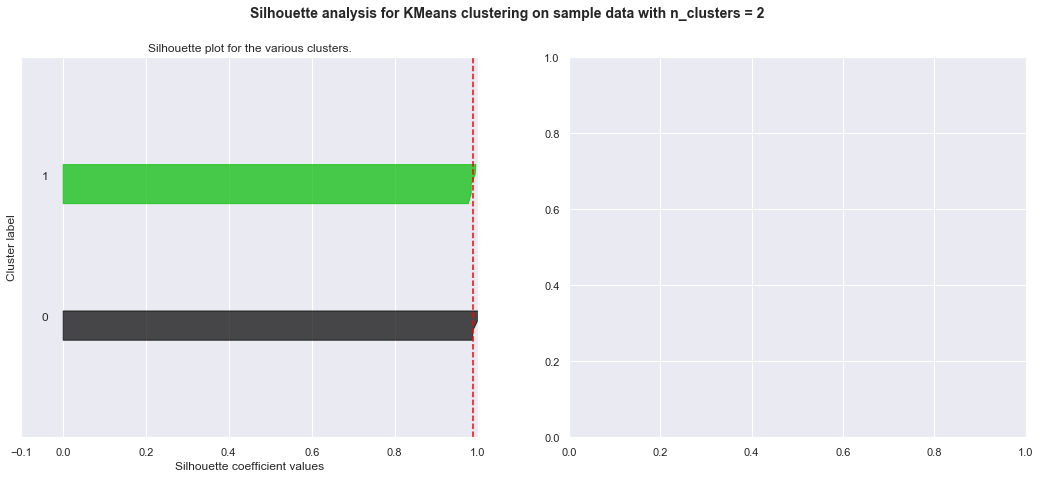

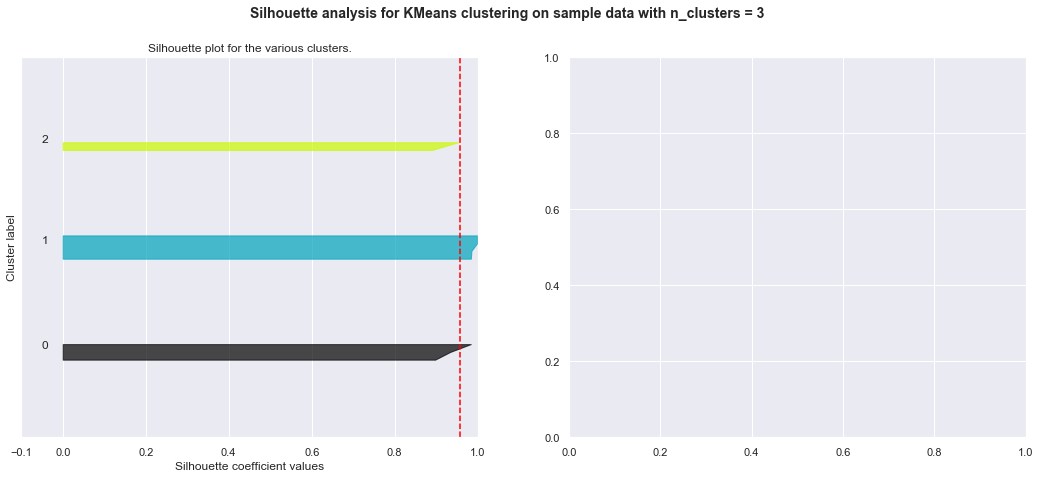

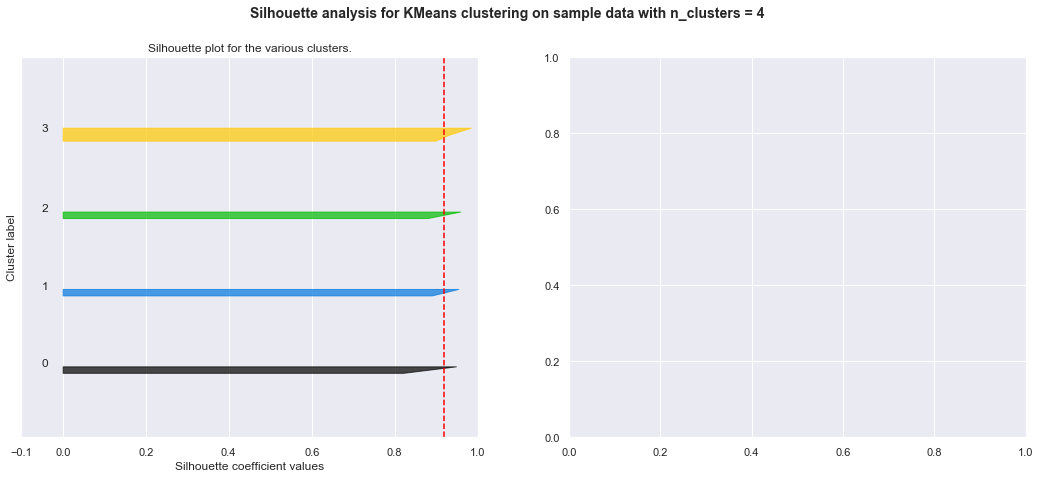

In [150]:
# get range of k values tested
k_range = %sql SELECT k FROM k_auto ORDER BY k;

# outer loop on k
# plot clusters for each k value
for n_clusters in k_range:
    
    # create table mapping each point to its centroid
    kval = n_clusters[0]
    %sql DROP TABLE IF EXISTS k_plot1;
    %sql CREATE TABLE k_plot1 AS (SELECT data.*, (madlib.closest_column(centroids, feature_vector, 'madlib.squared_dist_norm2')).column_id as cluster_id FROM training_data_work2 as data, k_auto WHERE k=$kval);

    # get info from tables and reshape to np arrays    
    # number of points
    num_points_proxy= %sql SELECT COUNT(*) FROM k_plot1;
    num_points= num_points_proxy[0][0]
    
    # points
    points_proxy = %sql SELECT feature_vector FROM k_plot1 ORDER BY pid;
    points = np.array(points_proxy).reshape(num_points,123) 
    
    # cluster id
    cluster_id_proxy = %sql SELECT cluster_id FROM k_plot1 ORDER BY pid;
    cluster_id = np.array(cluster_id_proxy).reshape(num_points)
    
    # centroids
    centroids_proxy = %sql SELECT centroids FROM k_auto WHERE k=$kval;
    centers = np.array(centroids_proxy[0][0]).reshape(kval,123)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = %sql SELECT silhouette FROM k_auto WHERE k=$kval;
    print("For n_clusters =", kval,
          "The average silhouette_score is :", silhouette_avg)
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
      
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    len_X = %sql select count(*) from training_data_work2;
    len_X = len_X[0][0]
    ax1.set_ylim([0, len_X + (kval + 1) * 10])
    
    y_lower = 10
    
    # inner loop on number of centroids 
    for i in range(kval):

        %sql DROP TABLE IF EXISTS points_distr1;
        %sql SELECT * FROM madlib.simple_silhouette_points( 'training_data_work2', 'points_distr1', 'pid', 'feature_vector', (SELECT centroids FROM k_auto WHERE k=$kval), 'madlib.squared_dist_norm2');
        ith_cluster_silhouette_values_proxy = %sql SELECT silh from points_distr1 WHERE centroid_id=$i ORDER BY silh;
        ith_cluster_silhouette_values = np.array(ith_cluster_silhouette_values_proxy).reshape(len(ith_cluster_silhouette_values_proxy))
        
        size_cluster_i_proxy = %sql SELECT COUNT(*) from points_distr1 WHERE centroid_id=$i;
        size_cluster_i = size_cluster_i_proxy[0][0]

        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / kval)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 
                  0, ith_cluster_silhouette_values, 
                  facecolor=color, edgecolor=color, alpha=0.7);
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i));

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
           
    ax1.set_title("Silhouette plot for the various clusters.")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    centroids = %sql SELECT centroid_id FROM points_distr1 ORDER BY pid;
    cluster_labels = np.array(centroids).reshape(len(centroids))
    
    colors = cm.nipy_spectral(cluster_labels.astype(float) / kval)
    #ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
    #            c=colors, edgecolor='k')

    # Labeling the clusters
    # Draw white circles at cluster centers
    #ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
    #            c="white", alpha=1, s=200, edgecolor='k')

    #for i, c in enumerate(centers):
    #    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
    #                s=50, edgecolor='k')

    #ax2.set_title("Visualization of the clustered data.")
    #ax2.set_xlabel("Feature space for the 1st feature")
    #ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % kval),
                 fontsize=14, fontweight='bold')

plt.show();

In [76]:
len_X = %sql select count(*) from training_data_work2;

1 rows affected.


In [79]:
len_X[0][0]

17L

### Nearest neighbors - v1

In [50]:
%%sql
drop table if exists temp1;
create table temp1 as
select * from training_data_encoded where y='class19' or y='class12';
select * from temp1;

Done.
5 rows affected.
5 rows affected.


a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25,a26,a27,a28,a29,a30,a31,a32,a33,a34,a35,a36,a37,a38,a39,a40,a41,a42,y,a1_ICMP,a1_TCP,a1_UDP,a2_AOL,a2_AUTH,a2_BGP,a2_COURIER,a2_CSNET_NS,a2_CTF,a2_DAYTIME,a2_DISCARD,a2_DOMAIN,a2_DOMAIN_U,a2_ECHO,a2_ECO_I,a2_ECR_I,a2_EFS,a2_EXEC,a2_FINGER,a2_FTP,a2_FTP_DATA,a2_GOPHER,a2_HARVEST,a2_HOSTNAMES,a2_HTTP,a2_HTTP_2784,a2_HTTP_443,a2_HTTP_8001,a2_IMAP4,a2_IRC,a2_ISO_TSAP,a2_KLOGIN,a2_KSHELL,a2_LDAP,a2_LINK,a2_LOGIN,a2_MTP,a2_NAME,a2_NETBIOS_DGM,a2_NETBIOS_NS,a2_NETBIOS_SSN,a2_NETSTAT,a2_NNSP,a2_NNTP,a2_NTP_U,a2_OTHER,a2_PM_DUMP,a2_POP_2,a2_POP_3,a2_PRINTER,a2_PRIVATE,a2_RED_I,a2_REMOTE_JOB,a2_RJE,a2_SHELL,a2_SMTP,a2_SQL_NET,a2_SSH,a2_SUNRPC,a2_SUPDUP,a2_SYSTAT,a2_TELNET,a2_TFTP_U,a2_TIME,a2_TIM_I,a2_URH_I,a2_URP_I,a2_UUCP,a2_UUCP_PATH,a2_VMNET,a2_WHOIS,a2_X11,a2_Z39_50,a3_STAT01,a3_STAT02,a3_STAT03,a3_STAT04,a3_STAT05,a3_STAT06,a3_STAT07,a3_STAT08,a3_STAT09,a3_STAT10,a3_STAT11
269.0,2333.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,382.0,0.01,25.0,0.06,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.03,0.0,69.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,class12,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
112.0,847.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1190.0,0.0,299.0,0.02,1.0,0.0,0.0,48.0,0.0,0.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.19,0.0,255.0,0.0,0.0,0.0,0.0,1.0,0.31,0.0,class19,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
237.0,1540.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1346.0,0.0,337.0,0.02,1.0,0.0,0.0,47.0,1.0,0.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.18,1.0,255.0,0.0,0.0,0.0,0.0,1.0,0.32,0.0,class19,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
268.0,2364.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,954.0,0.0,45.0,0.02,1.0,0.0,0.0,2.0,1.0,0.0,0.69,0.0,2.0,0.0,0.0,0.0,0.0,0.01,0.0,255.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,class12,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
260.0,2635.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,1149.0,0.0,54.0,0.01,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,class12,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [61]:
%%sql
DROP TABLE IF EXISTS temp1_summary;
SELECT * FROM madlib.summary( 'temp1',   -- Source table
                              'temp1_summary',    -- Output table
                              NULL,      -- summarize all columns
                              'y'    -- grouping 
                            );
select group_by_value, lower(target_column)::VARCHAR, column_number, mean from temp1_summary  where group_by='y' order by group_by, group_by_value, column_number;

Done.
1 rows affected.
246 rows affected.


group_by_value,lower,column_number,mean
class12,a4,1,265.666666667
class12,a5,2,2444.0
class12,a6,3,0.0
class12,a7,4,0.0
class12,a8,5,0.0
class12,a9,6,1.0
class12,a10,7,1.0
class12,a11,8,0.0
class12,a12,9,2.0
class12,a13,10,0.0


In [72]:
%%sql
DROP TABLE IF EXISTS temp2;
create table temp2 as
select group_by_value, target_column, mean from temp1_summary 
  where (target_column='a4' or target_column='a5') and group_by_value<>'None'
  order by group_by_value, target_column;
select * from temp2 order by group_by_value, target_column;

Done.
4 rows affected.
4 rows affected.


group_by_value,target_column,mean
class12,a4,265.666666667
class12,a5,2444.0
class19,a4,174.5
class19,a5,1193.5


In [74]:
%%sql
DROP TABLE IF EXISTS temp3;
SELECT madlib.pivot('temp2', 'temp3', 'group_by_value', 'target_column', 'mean');
SELECT * FROM temp3;

Done.
1 rows affected.
2 rows affected.


group_by_value,mean_avg_target_column_a4,mean_avg_target_column_a5
class19,174.5,1193.5
class12,265.666666667,2444.0


### Nearest neighbors - v2

In [10]:
%%sql
drop table if exists temp1;
  create table temp1 as 
  select * from training_data;

Done.
4898431 rows affected.


[]

In [11]:
%%sql
drop table if exists temp2;
  create table temp2 as  
  select LOWER(a1) as a1, LOWER(a2) as a2, LOWER(a3) as a3, 
    a4,
    a5,
    a6 ,
    a7 ,
    a8 ,
    a9 ,
    a10 ,
    a11 ,
    a12 ,
    a13 ,
    a14 ,
    a15 ,
    a16 ,
    a17 ,
    a18 ,
    a19 ,
    a20 ,
    a21 ,
    a22 ,
    a23 ,
    a24 ,
    a25 ,
    a26 ,
    a27 ,
    a28 ,
    a29 ,
    a30 ,
    a31 ,
    a32 ,
    a33 ,
    a34 ,
    a35 ,
    a36 ,
    a37 ,
    a38 ,
    a39 ,
    a40 ,
    a41 ,
    a42 ,
    y from temp1;

Done.
4898431 rows affected.


[]

In [12]:
%%sql
select * from temp2 limit 5;

5 rows affected.


a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25,a26,a27,a28,a29,a30,a31,a32,a33,a34,a35,a36,a37,a38,a39,a40,a41,a42,y
tcp,private,stat02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06,0.0,1952.0,0.0,0.0,0.08,16.0,0.0,1.0,16.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.06,0.0,255.0,0.0,0.0,0.06,0.0,290.0,0.0,0.0,class10
icmp,ecr_i,stat10,520.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1329.0,1.0,0.0,0.0,511.0,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0.0,class18
icmp,ecr_i,stat10,520.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,724.0,1.0,0.0,0.0,511.0,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0.0,class18
udp,other,stat10,146.0,105.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,1382.0,1.0,6420.0,0.82,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0,0.6,0.0,5.0,0.0,0.0,normal
tcp,http,stat02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,269.0,0.01,0.0,0.0,1.0,0.0,1.0,255.0,0.0,0.0,0.37,0.02,0.0,0.0,0.35,1.0,0.0,1.0,0.0,191.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,normal


In [13]:
%%sql
DROP TABLE IF EXISTS training_data_encoded, training_data_encoded_dictionary;
SELECT madlib.encode_categorical_variables (
        'temp2',            -- Source table
        'training_data_encoded',      -- Output table
        'a1, a2, a3'                        -- Categorical columns
        );

Done.
1 rows affected.


encode_categorical_variables
""


In [14]:
%%sql
select * from training_data_encoded limit 5;

5 rows affected.


a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25,a26,a27,a28,a29,a30,a31,a32,a33,a34,a35,a36,a37,a38,a39,a40,a41,a42,y,a1_icmp,a1_tcp,a1_udp,a2_aol,a2_auth,a2_bgp,a2_courier,a2_csnet_ns,a2_ctf,a2_daytime,a2_discard,a2_domain,a2_domain_u,a2_echo,a2_eco_i,a2_ecr_i,a2_efs,a2_exec,a2_finger,a2_ftp,a2_ftp_data,a2_gopher,a2_harvest,a2_hostnames,a2_http,a2_http_2784,a2_http_443,a2_http_8001,a2_imap4,a2_irc,a2_iso_tsap,a2_klogin,a2_kshell,a2_ldap,a2_link,a2_login,a2_mtp,a2_name,a2_netbios_dgm,a2_netbios_ns,a2_netbios_ssn,a2_netstat,a2_nnsp,a2_nntp,a2_ntp_u,a2_other,a2_pm_dump,a2_pop_2,a2_pop_3,a2_printer,a2_private,a2_red_i,a2_remote_job,a2_rje,a2_shell,a2_smtp,a2_sql_net,a2_ssh,a2_sunrpc,a2_supdup,a2_systat,a2_telnet,a2_tftp_u,a2_time,a2_tim_i,a2_urh_i,a2_urp_i,a2_uucp,a2_uucp_path,a2_vmnet,a2_whois,a2_x11,a2_z39_50,a3_stat01,a3_stat02,a3_stat03,a3_stat04,a3_stat05,a3_stat06,a3_stat07,a3_stat08,a3_stat09,a3_stat10,a3_stat11
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06,0.0,1952.0,0.0,0.0,0.08,16.0,0.0,1.0,16.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.06,0.0,255.0,0.0,0.0,0.06,0.0,290.0,0.0,0.0,class10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
520.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,724.0,1.0,0.0,0.0,511.0,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0.0,class18,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,269.0,0.01,0.0,0.0,1.0,0.0,1.0,255.0,0.0,0.0,0.37,0.02,0.0,0.0,0.35,1.0,0.0,1.0,0.0,191.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,normal,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,410.0,1.0,0.0,0.0,511.0,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0.0,class18,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
105.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1355.0,0.01,0.0,0.01,2.0,0.0,0.0,244.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.96,0.0,255.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,normal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [6]:
%%sql
DROP TABLE IF EXISTS training_data_encoded_summary;
SELECT * FROM madlib.summary( 'training_data_encoded',   -- Source table
                              'training_data_encoded_summary',    -- Output table
                              NULL,      -- summarize all columns
                              'y',    -- grouping 
                             NULL,
                             NULL,
                             NULL,
                             NULL,
                             NULL,
                             5
                            );

Done.
1 rows affected.


output_table,num_col_summarized,duration
training_data_encoded_summary,2953,2203.32710981


In [6]:
%%sql
select group_by, group_by_value, target_column, column_number, mean, variance, min, max from training_data_encoded_summary where target_column='a5' order by group_by, group_by_value, column_number;

24 rows affected.


group_by,group_by_value,target_column,column_number,mean,variance,min,max
y,class01,a5,2,8232.64956877,379741.624644,0.0,8315.0
y,class02,a5,2,6339.83333333,154770140.006,698.0,70529.0
y,class03,a5,2,5382.25,190267195.071,0.0,39445.0
y,class04,a5,2,216.188679245,66307.425254,179.0,2053.0
y,class05,a5,2,54948.6666667,35028267137.7,0.0,649186.0
y,class06,a5,2,4.39435942633,213624.956968,0.0,51633.0
y,class07,a5,2,0.0,0.0,0.0,0.0
y,class08,a5,2,3009.88888889,8453135.86111,644.0,8876.0
y,class09,a5,2,213016.285714,1.46372051222e+11,0.0,988002.0
y,class10,a5,2,0.000820882504662,0.722376604102,0.0,880.0


In [11]:
%%sql
drop table if exists training_data_encoded_summary_all;
create table training_data_encoded_summary_all as
  select * from training_data_encoded_summary where group_by is NULL;
select * from training_data_encoded_summary_all order by column_number;

Done.
124 rows affected.
124 rows affected.


group_by,group_by_value,target_column,column_number,data_type,row_count,missing_values,blank_values,fraction_missing,fraction_blank,positive_values,negative_values,zero_values,mean,variance,confidence_interval,min,max,most_frequent_values,mfv_frequencies
None,None,a4,1,float8,4898431,0,None,0.0,None,3745885,0,1152546,1832.10418316,8.86292473315e+11,"[998.392083442871, 2665.81628286871]",0.0,1379963888.0,"[u'1032', u'0', u'520', u'105', u'147', u'146', u'42', u'8', u'44', u'145']","[2255724L, 1152559L, 545377L, 73912L, 27348L, 20378L, 10755L, 10529L, 9236L, 9224L]"
None,None,a5,2,float8,4898431,0,None,0.0,None,833577,0,4064854,1093.62281371,4.1604091068e+11,"[522.413088360923, 1664.83253906549]",0.0,1309937401.0,"[u'0', u'105', u'147', u'146', u'145', u'42', u'330', u'329', u'331', u'332']","[4065027L, 44906L, 25045L, 22935L, 9632L, 9410L, 8425L, 7908L, 7886L, 7415L]"
None,None,a6,3,float8,4898431,0,None,0.0,None,4091,0,4894340,0.000835165382548,0.000834468051686,"[0.000809583504108748, 0.00086074726098726]",0.0,1.0,"[u'0', u'1']","[4894340L, 4091L]"
None,None,a7,4,float8,4898431,0,None,0.0,None,2,0,4898429,4.08294002712e-07,4.0829391936e-07,"[-1.57572557277603e-07, 9.74160562702197e-07]",0.0,1.0,"[u'0', u'1']","[4898429L, 2L]"
None,None,a8,5,float8,4898431,0,None,0.0,None,110,0,4898321,3.67464602441e-05,6.53257034677e-05,"[2.95888240326134e-05, 4.39040964556e-05]",0.0,2.0,"[u'0', u'2', u'1']","[4898321L, 70L, 40L]"
None,None,a9,6,float8,4898431,0,None,0.0,None,334,0,4898097,6.8185098453e-05,6.81804631641e-05,"[6.08727387362456e-05, 7.54974581696616e-05]",0.0,1.0,"[u'0', u'1']","[4898097L, 334L]"
None,None,a10,7,float8,4898431,0,None,0.0,None,703067,0,4195364,0.143529019802,0.122928465372,"[0.143218525379488, 0.143839514225438]",0.0,1.0,"[u'0', u'1']","[4195364L, 703067L]"
None,None,a11,8,float8,4898431,0,None,0.0,None,28,0,4898403,5.71611603797e-06,5.71608453091e-06,"[3.59884286293686e-06, 7.83338921300746e-06]",0.0,1.0,"[u'0', u'1']","[4898403L, 28L]"
None,None,a12,9,float8,4898431,0,None,0.0,None,2352,0,4896079,0.0011887479889,0.0154221001261,"[0.00107877163096967, 0.00129872434682404]",0.0,43.0,"[u'0', u'1', u'2', u'4', u'17', u'12', u'14', u'13', u'20', u'11']","[4896079L, 1792L, 359L, 15L, 13L, 10L, 10L, 9L, 9L, 8L]"
None,None,a13,10,float8,4898431,0,None,0.0,None,338716,0,4559715,0.0282601735127,0.019756641795,"[0.0281356979389264, 0.0283846490864496]",0.0,1.0,"[u'0', u'1', u'0.12', u'0.5', u'0.67', u'0.11', u'0.33', u'0.25', u'0.1', u'0.14']","[4559715L, 78820L, 14656L, 12645L, 12413L, 11857L, 11619L, 11060L, 10736L, 10677L]"


In [14]:
%%sql
drop table if exists work1;
create table work1 as 
  select * from training_data_encoded limit 10;
select * from work1;

Done.
10 rows affected.
10 rows affected.


a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25,a26,a27,a28,a29,a30,a31,a32,a33,a34,a35,a36,a37,a38,a39,a40,a41,a42,y,a1_icmp,a1_tcp,a1_udp,a2_aol,a2_auth,a2_bgp,a2_courier,a2_csnet_ns,a2_ctf,a2_daytime,a2_discard,a2_domain,a2_domain_u,a2_echo,a2_eco_i,a2_ecr_i,a2_efs,a2_exec,a2_finger,a2_ftp,a2_ftp_data,a2_gopher,a2_harvest,a2_hostnames,a2_http,a2_http_2784,a2_http_443,a2_http_8001,a2_imap4,a2_irc,a2_iso_tsap,a2_klogin,a2_kshell,a2_ldap,a2_link,a2_login,a2_mtp,a2_name,a2_netbios_dgm,a2_netbios_ns,a2_netbios_ssn,a2_netstat,a2_nnsp,a2_nntp,a2_ntp_u,a2_other,a2_pm_dump,a2_pop_2,a2_pop_3,a2_printer,a2_private,a2_red_i,a2_remote_job,a2_rje,a2_shell,a2_smtp,a2_sql_net,a2_ssh,a2_sunrpc,a2_supdup,a2_systat,a2_telnet,a2_tftp_u,a2_time,a2_tim_i,a2_urh_i,a2_urp_i,a2_uucp,a2_uucp_path,a2_vmnet,a2_whois,a2_x11,a2_z39_50,a3_stat01,a3_stat02,a3_stat03,a3_stat04,a3_stat05,a3_stat06,a3_stat07,a3_stat08,a3_stat09,a3_stat10,a3_stat11
145.0,105.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,935.0,1.0,2630.0,0.85,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,normal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,771.0,1.0,0.0,0.0,510.0,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,510.0,0.0,0.0,class18,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.18,0.0,279.0,0.0,0.0,0.05,25.0,0.0,0.0,25.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.1,0.0,255.0,0.0,0.0,0.04,1.0,141.0,1.0,0.0,class10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06,0.0,762.0,0.0,0.0,0.06,8.0,0.0,0.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.03,0.0,255.0,0.0,0.0,0.06,1.0,137.0,1.0,0.0,class10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
105.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1205.0,0.01,0.0,0.01,2.0,0.0,0.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.88,0.0,255.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,normal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.0,675.0,0.0,0.0,0.07,8.0,0.0,0.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.03,0.0,255.0,0.0,0.0,0.06,1.0,276.0,1.0,0.0,class10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,20.0,1.0,0.0,0.0,511.0,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0.0,class18,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,1560.0,0.0,0.0,0.06,2.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.01,0.0,255.0,0.0,0.0,0.07,0.0,102.0,0.0,0.0,class10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1174.0,1.0,0.0,0.0,511.0,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0.0,class18,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
%%sql
drop table if exists drop table if exists work2;
create table work2 as
DROP TABLE IF EXISTS training_data_encoded_summary;

In [157]:
%%sql
drop table if exists temp3;
create table temp3 as
select * from training_data_encoded where y='class19';
select * from temp3;

Done.
2 rows affected.
2 rows affected.


a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25,a26,a27,a28,a29,a30,a31,a32,a33,a34,a35,a36,a37,a38,a39,a40,a41,a42,y,a1_icmp,a1_tcp,a1_udp,a2_aol,a2_auth,a2_bgp,a2_courier,a2_csnet_ns,a2_ctf,a2_daytime,a2_discard,a2_domain,a2_domain_u,a2_echo,a2_eco_i,a2_ecr_i,a2_efs,a2_exec,a2_finger,a2_ftp,a2_ftp_data,a2_gopher,a2_harvest,a2_hostnames,a2_http,a2_http_2784,a2_http_443,a2_http_8001,a2_imap4,a2_irc,a2_iso_tsap,a2_klogin,a2_kshell,a2_ldap,a2_link,a2_login,a2_mtp,a2_name,a2_netbios_dgm,a2_netbios_ns,a2_netbios_ssn,a2_netstat,a2_nnsp,a2_nntp,a2_ntp_u,a2_other,a2_pm_dump,a2_pop_2,a2_pop_3,a2_printer,a2_private,a2_red_i,a2_remote_job,a2_rje,a2_shell,a2_smtp,a2_sql_net,a2_ssh,a2_sunrpc,a2_supdup,a2_systat,a2_telnet,a2_tftp_u,a2_time,a2_tim_i,a2_urh_i,a2_urp_i,a2_uucp,a2_uucp_path,a2_vmnet,a2_whois,a2_x11,a2_z39_50,a3_stat01,a3_stat02,a3_stat03,a3_stat04,a3_stat05,a3_stat06,a3_stat07,a3_stat08,a3_stat09,a3_stat10,a3_stat11
112.0,847.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1190.0,0.0,299.0,0.02,1.0,0.0,0.0,48.0,0.0,0.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.19,0.0,255.0,0.0,0.0,0.0,0.0,1.0,0.31,0.0,class19,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
237.0,1540.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1346.0,0.0,337.0,0.02,1.0,0.0,0.0,47.0,1.0,0.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.18,1.0,255.0,0.0,0.0,0.0,0.0,1.0,0.32,0.0,class19,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [159]:
%%sql
DROP TABLE IF EXISTS temp4;
create table temp4 as
select * from temp3_summary where group_by = 'y';

Done.
123 rows affected.


[]

In [160]:
%%sql
DROP TABLE IF EXISTS temp5;
SELECT madlib.pivot('temp4', 'temp5', 'group_by_value', 'target_column', 'mean');
SELECT * FROM temp5;

Done.
1 rows affected.
1 rows affected.


group_by_value,mean_avg_target_column_a10,mean_avg_target_column_a11,mean_avg_target_column_a12,mean_avg_target_column_a13,mean_avg_target_column_a14,mean_avg_target_column_a15,mean_avg_target_column_a16,mean_avg_target_column_a17,mean_avg_target_column_a18,mean_avg_target_column_a19,mean_avg_target_column_a1_icmp,mean_avg_target_column_a1_tcp,mean_avg_target_column_a1_udp,mean_avg_target_column_a20,mean_avg_target_column_a21,mean_avg_target_column_a22,mean_avg_target_column_a23,mean_avg_target_column_a24,mean_avg_target_column_a25,mean_avg_target_column_a26,mean_avg_target_column_a27,mean_avg_target_column_a28,mean_avg_target_column_a29,mean_avg_target_column_a2_aol,mean_avg_target_column_a2_auth,mean_avg_target_column_a2_bgp,mean_avg_target_column_a2_courier,mean_avg_target_column_a2_csnet_ns,mean_avg_target_column_a2_ctf,mean_avg_target_column_a2_daytime,mean_avg_target_column_a2_discard,mean_avg_target_column_a2_domain,mean_avg_target_column_a2_domain_u,mean_avg_target_column_a2_echo,mean_avg_target_column_a2_eco_i,mean_avg_target_column_a2_ecr_i,mean_avg_target_column_a2_efs,mean_avg_target_column_a2_exec,mean_avg_target_column_a2_finger,mean_avg_target_column_a2_ftp,mean_avg_target_column_a2_ftp_data,mean_avg_target_column_a2_gopher,mean_avg_target_column_a2_harvest,mean_avg_target_column_a2_hostnames,mean_avg_target_column_a2_http,mean_avg_target_column_a2_http_2784,mean_avg_target_column_a2_http_443,mean_avg_target_column_a2_http_8001,mean_avg_target_column_a2_imap4,mean_avg_target_column_a2_irc,mean_avg_target_column_a2_iso_tsap,mean_avg_target_column_a2_klogin,mean_avg_target_column_a2_kshell,mean_avg_target_column_a2_ldap,mean_avg_target_column_a2_link,mean_avg_target_column_a2_login,mean_avg_target_column_a2_mtp,mean_avg_target_column_a2_name,mean_avg_target_column_a2_netbios_dgm,mean_avg_target_column_a2_netbios_ns,mean_avg_target_column_a2_netbios_ssn,mean_avg_target_column_a2_netstat,mean_avg_target_column_a2_nnsp,mean_avg_target_column_a2_nntp,mean_avg_target_column_a2_ntp_u,mean_avg_target_column_a2_other,mean_avg_target_column_a2_pm_dump,mean_avg_target_column_a2_pop_2,mean_avg_target_column_a2_pop_3,mean_avg_target_column_a2_printer,mean_avg_target_column_a2_private,mean_avg_target_column_a2_red_i,mean_avg_target_column_a2_remote_job,mean_avg_target_column_a2_rje,mean_avg_target_column_a2_shell,mean_avg_target_column_a2_smtp,mean_avg_target_column_a2_sql_net,mean_avg_target_column_a2_ssh,mean_avg_target_column_a2_sunrpc,mean_avg_target_column_a2_supdup,mean_avg_target_column_a2_systat,mean_avg_target_column_a2_telnet,mean_avg_target_column_a2_tftp_u,mean_avg_target_column_a2_tim_i,mean_avg_target_column_a2_time,mean_avg_target_column_a2_urh_i,mean_avg_target_column_a2_urp_i,mean_avg_target_column_a2_uucp,mean_avg_target_column_a2_uucp_path,mean_avg_target_column_a2_vmnet,mean_avg_target_column_a2_whois,mean_avg_target_column_a2_x11,mean_avg_target_column_a2_z39_50,mean_avg_target_column_a30,mean_avg_target_column_a31,mean_avg_target_column_a32,mean_avg_target_column_a33,mean_avg_target_column_a34,mean_avg_target_column_a35,mean_avg_target_column_a36,mean_avg_target_column_a37,mean_avg_target_column_a38,mean_avg_target_column_a39,mean_avg_target_column_a3_stat01,mean_avg_target_column_a3_stat02,mean_avg_target_column_a3_stat03,mean_avg_target_column_a3_stat04,mean_avg_target_column_a3_stat05,mean_avg_target_column_a3_stat06,mean_avg_target_column_a3_stat07,mean_avg_target_column_a3_stat08,mean_avg_target_column_a3_stat09,mean_avg_target_column_a3_stat10,mean_avg_target_column_a3_stat11,mean_avg_target_column_a4,mean_avg_target_column_a40,mean_avg_target_column_a41,mean_avg_target_column_a42,mean_avg_target_column_a5,mean_avg_target_column_a6,mean_avg_target_column_a7,mean_avg_target_column_a8,mean_avg_target_column_a9
class19,0.5,0.0,0.5,0.0,1.0,0.0,1268.0,0.0,318.0,0.02,0.0,1.0,0.0,1.0,0.0,0.0,47.5,0.5,0.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [161]:
%%sql
drop table if exists temp6, temp6_summary;
select madlib.cols2vec('temp5',
                       'temp6',
                       '*',
                       'group_by_value',
                       'group_by_value'
                       );

Done.
1 rows affected.


cols2vec
""


In [162]:
%%sql
alter table temp6
rename column group_by_value to y;

Done.


[]

In [163]:
%%sql
select * from temp6;

1 rows affected.


y,feature_vector
class19,"[0.5, 0.0, 0.5, 0.0, 1.0, 0.0, 1268.0, 0.0, 318.0, 0.02, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 47.5, 0.5, 0.22, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.185, 0.5, 255.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 174.5, 1.0, 0.315, 0.0, 1193.5, 0.0, 0.0, 0.5, 0.0]"


In [165]:
%%sql
drop table if exists temp7, temp7_summary;
select madlib.cols2vec('training_data_encoded',
                       'temp7',
                       '*',
                       'y',
                       'y'
                       );

Done.
1 rows affected.


cols2vec
""


In [166]:
%%sql
select * from temp7 limit 5;

5 rows affected.


y,feature_vector
class18,"[520.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1326.0, 1.0, 0.0, 0.0, 461.0, 0.0, 0.0, 255.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 255.0, 0.0, 0.0, 0.0, 0.0, 461.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
class18,"[1032.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1551.0, 1.0, 0.0, 0.0, 511.0, 0.0, 0.0, 255.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 255.0, 0.0, 0.0, 0.0, 0.0, 511.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
class10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12, 0.0, 882.0, 0.0, 0.0, 0.07, 14.0, 0.0, 0.0, 14.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.05, 0.0, 255.0, 0.0, 0.0, 0.07, 1.0, 120.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
class10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.0, 1314.0, 0.0, 0.0, 0.08, 10.0, 0.0, 0.0, 10.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.04, 0.0, 255.0, 0.0, 0.0, 0.15, 1.0, 33.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
class18,"[1032.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 637.0, 1.0, 0.0, 0.0, 510.0, 0.0, 0.0, 255.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 255.0, 0.0, 0.0, 0.0, 0.0, 510.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"


In [167]:
%%sql
create table temp8 as
  select temp6.y as from_class , temp7.y as to_class, madlib.squared_dist_norm2(temp6.feature_vector, temp7.feature_vector) from temp6, temp7;

4898431 rows affected.


[]

In [176]:
%%sql
select * from temp8 order by squared_dist_norm2 asc limit 100;

100 rows affected.


from_class,to_class,squared_dist_norm2
class19,class06,3229143.39225
class19,class06,3229183.46715
class19,normal,3229235.79615
class19,normal,3229428.18865
class19,class06,3229477.42315
class19,class06,3229693.43385
class19,class06,3229735.41265
class19,class06,3229845.41265
class19,class06,3229955.39225
class19,normal,3230196.09535


----
## Feature Engineering

<a id="fe_continuous"></a>
#### Continuous Features

In [ ]:
# continuos features (seperated out incase feature transformations are required)
query = """
    DROP TABLE IF EXISTS public.model_inputs_cont;
    CREATE TABLE public.model_inputs_cont AS
    SELECT _id
          ,a16 AS approval
          ,a2
          ,a3
          ,a8
          ,a11
          ,a14
          ,a15
    FROM public.credit_application_data
    DISTRIBUTED BY (_id);
    SELECT * FROM public.model_inputs_cont LIMIT 0;
"""
cur.execute(query)

contFeatureNames = [desc[0] for desc in cur.description]
contFeatureNames.remove('_id')
contFeatureNames.remove('approval')

query = """
    SELECT *
    FROM public.model_inputs_cont
"""
df = query_gpdb(query)

df.head()

<a id="fe_one_hot"></a>
#### One Hot Encode Categorical Features

https://madlib.apache.org/docs/latest/group__grp__encode__categorical.html

In [ ]:
# encode categorical features
query = """
    DROP TABLE IF EXISTS public.model_inputs_cat;
    SELECT madlib.encode_categorical_variables (
        'public.credit_application_data',
        'public.model_inputs_cat',
        'a1,a4,a5,a6,a7,a9,a10,a12,a13',
        NULL,
        '_id',
        NULL,
        'a1=b, a4=y, a5=p, a6=x, a7=z, a9=false, a10=false, a12=false, a13=s'
    );
"""
cur.execute(query)

query = """
    SELECT *
    FROM public.model_inputs_cat
"""
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
df = pd.DataFrame(cur.fetchall(), columns=colnames)

colnames.remove('_id')
catFeatureNames = colnames
featureNames = contFeatureNames + catFeatureNames
print(featureNames)
df.head()

<a id="fe_combine"></a>
#### Combine Continuous & Categorical Features

In [ ]:
# combine feature tables
query = """
    DROP TABLE IF EXISTS public.model_inputs;
    CREATE TABLE public.model_inputs AS
    SELECT *
    FROM public.model_inputs_cat
    JOIN public.model_inputs_cont
    USING (_id);
"""
cur.execute(query)

<a id="fe_cats_dep"></a>
#### Plot Categorical Features By Response

In [ ]:
def bar_plot_groupby(data, title,x,xLabel,y,yLabel,groupby,color=None,axisRotation=90):

    # Bar plot
    pylab.rcParams['figure.figsize'] = (12, 8)
    seq_col_brew = sns.color_palette("Blues_r", 1)
    sns.color_palette(seq_col_brew)
    if color != None:
        plt = sns.barplot(x=x, y=y, data=data, color=color, hue=groupby)
    else:
        plt = sns.barplot(x=x, y=y, data=data, hue=groupby)
        
    # titles
    plt.set_title(title,fontsize=30)
    plt.set_xlabel(xLabel,fontsize=16)
    plt.set_ylabel(yLabel,fontsize=16)
    
    # rotate x axis labels
    for item in plt.get_xticklabels():
        item.set_rotation(axisRotation)

    # remove scientific notation
    plt.ticklabel_format(style='plain', axis='y')

def get_cat_gb_data_frame(col):
    query = """
        SELECT *
              ,round((record_count * 100.0) / sum(record_count) OVER(PARTITION BY col),2) AS perc_records
        FROM (
            SELECT {} AS col
                  ,approval
                  ,count(*) AS record_count
            FROM public.model_inputs
            GROUP BY 1,2
        ) foo
        ORDER BY 1,2
    """.format(col)
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    return pd.DataFrame(cur.fetchall(), columns=colnames)
    
def on_cat_gb_selection(res):
    if res['type'] == 'change' and res['name'] == 'value':
        ipd.clear_output()
        printmd("-----\n **Select Column:**")
        ipd.display(catGPDropdown)
        df = get_cat_gb_data_frame(res['new'])
        bar_plot_groupby(df,res['new'],"col",res['new'],"perc_records","% Class Records", "approval")
    
catGPDropdown = widgets.Dropdown(
    options=catFeatureNames,
    value=catFeatureNames[0],
    description='Column:',
    disabled=False,
)

catGPDropdown.observe(on_cat_gb_selection)
printmd("-----\n **Select Column:**")
ipd.display(catGPDropdown)
df = get_cat_gb_data_frame(catFeatureNames[0])
bar_plot_groupby(df,catFeatureNames[0],"col",catFeatureNames[0],"perc_records","% Class Records","approval")

* a9_true appears to be a strong variable due to seperate between classes

<a id="fe_chi_sq"></a>
#### Chi-squared testing

https://en.wikipedia.org/wiki/Chi-squared_test

https://madlib.apache.org/docs/latest/group__grp__stats__tests.html

In [ ]:
def chi2_gof_test(feature_name, response):
    query = """
        WITH freq AS (
            SELECT {feature_name}
                  ,{response}
                  ,count(*) AS observed
            FROM public.model_inputs
            GROUP BY 1,2
        )
        SELECT '{feature_name}' AS feature_name
              ,'{response}' AS response
              ,(madlib.chi2_gof_test(observed, expected, deg_freedom)).*
        FROM (
            SELECT observed
                  ,sum(observed) OVER (PARTITION BY {feature_name})::DOUBLE PRECISION
                       * sum(observed) OVER (PARTITION BY {response}) AS expected
            FROM freq
        ) l, (
            SELECT (count(distinct {feature_name}) - 1) * (count(distinct {response}) - 1) AS deg_freedom
            FROM freq
        ) r;
    """.format(feature_name=feature_name, response=response)
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    return pd.DataFrame(cur.fetchall(), columns=colnames)

def chi2_gof_test_multi(feature_list, response):
    res = chi2_gof_test(feature_list[0], response)
    for i in range(1,len(feature_list)):
        res = res.append(chi2_gof_test(feature_list[i], response))
        
    return res

chi2_results = chi2_gof_test_multi(catFeatureNames, 'approval')
chi2_results.sort_values('phi', inplace=True)
ipd.display(chi2_results)
bar_plot(chi2_results, "Chi-Squared Testing","feature_name","Feature Name","phi","Test Statistic", "#4378E2")

<a id="fe_corr"></a>
#### Correlation Testing

https://madlib.apache.org/docs/latest/group__grp__correlation.html

In [ ]:
# calc correlations
query = """
    DROP TABLE IF EXISTS public.feature_correlations, public.feature_correlations_summary;
    SELECT madlib.correlation( 
        'public.model_inputs',
        'public.feature_correlations',
        '{}'
    );
    SELECT * 
    FROM public.feature_correlations
    ORDER BY column_position;
""".format(",".join(contFeatureNames))
corr = query_gpdb(query)

corr.drop('column_position', 'columns', inplace=True)
corr.set_index('variable', True, False, True)
corr

In [ ]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

<a id="fe_scatter"></a>
#### Scatter Plots

In [ ]:
def sample_scatter(title, x, xLabel, y, yLabel, sampleSize):
    
    pylab.rcParams['figure.figsize'] = (8, 8)

    # Grab sample
    query = """
        SELECT count(*) AS n
        FROM public.model_inputs;
    """.format(",".join(contFeatureNames))
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    n = pd.DataFrame(cur.fetchall(), columns=colnames)['n'][0]
    limit = math.floor(n * sampleSize)
    
    query = """
        SELECT {} AS col1
              ,{} AS col2
        FROM public.model_inputs
        LIMIT {};
    """.format(x, y, limit)
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    sample = pd.DataFrame(cur.fetchall(), columns=colnames)    
    
    # Generate scatterplot
    if x == y:
        sample
    plt = sns.regplot(x="col1", y="col2", data=sample)
    
    # titles
    plt.set_title("\n".join(tw.wrap(title,50)),fontsize=16)
    plt.set_xlabel(xLabel,fontsize=16)
    plt.set_ylabel(yLabel,fontsize=16)

    # add 1000s commas
    plt.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
    plt.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

In [ ]:
x = contFeatureNames[0]
y = contFeatureNames[1]

def reset():
    ipd.clear_output()
    printmd("-----\n **Select Features:**")
    ipd.display(scatterDropdown1, scatterDropdown2)

    sample_scatter("{} by {}".format(x, y), x, x, y, y, 1)   
    
def os1(res):
    global x
    if res['type'] == 'change' and res['name'] == 'value':
        contFeatureNames.append(x)
        x = res['new']
        contFeatureNames.remove(x)
        reset()

def os2(res):
    global y
    if res['type'] == 'change' and res['name'] == 'value':
        y = res['new']
        reset()
                   
scatterDropdown1 = widgets.Dropdown(
    options=contFeatureNames,
    value=x,
    description='x:',
    disabled=False,
)

scatterDropdown2 = widgets.Dropdown(
    options=contFeatureNames,
    value=y,
    description='y:',
    disabled=False,
)

scatterDropdown1.observe(os1)
scatterDropdown2.observe(os2)

reset()


----
## Model Training

<a id="train_vali_split"></a>
#### Training & Validation Sample Split

https://madlib.apache.org/docs/latest/group__grp__train__test__split.html

In [ ]:
# split training and validation set
# we are careful not to include the same customer in both sets
query = """
    DROP TABLE IF EXISTS public.model
                        ,public.model_train
                        ,public.model_test;
                        
    SELECT madlib.train_test_split(
        'public.model_inputs',
        'public.model',
        0.7,
        NULL,
        NULL,
        '*',
        FALSE,
        TRUE
    )
"""
cur.execute(query)

In [ ]:
query = """
    SELECT *
    FROM public.model_train
    LIMIT 5
"""
df = query_gpdb(query)
df

### Random Forest (MADlib)

Sample get 1 run out

In [21]:
%%sql
DROP TABLE IF EXISTS training_data_sample1;
SELECT madlib.balance_sample(
                              'training_data',             -- Source table
                              'training_data_sample1',      -- Output table
                              'y',           -- Class column
                              'uniform',           -- Uniform sample
                               2300);                -- Desired output table size

Done.
1 rows affected.


balance_sample
""


<a id="rf_train_model"></a>
#### Train model

https://madlib.apache.org/docs/latest/group__grp__random__forest.html

In [26]:
%%sql
DROP TABLE IF EXISTS rf_model1, rf_model1_summary, rf_model1_group;
SELECT madlib.forest_train(
            'training_data_sample1',  -- source table
            'rf_model1',              -- output table
            '__madlib_id__',          -- unique row id
            'y',                      -- dependent var
            '*',                      -- indep var
            null,                     -- cols to exclude
            null,                     -- grouping
            10::integer,              -- num trees
            5::integer,               -- num random features
            true::boolean,            -- importance
            5::integer,               -- num permutations
            10::integer,              -- max tree depth
            3::integer,               -- min split
            1::integer,               -- min bucket
            10::integer,               -- num splits
            NULL,                     -- null handling
            TRUE                      -- verbose
        );

Done.
1 rows affected.


forest_train
""


In [27]:
# view model summary
query = """
    SELECT gid, sample_id
    FROM rf_model1
"""

df = query_gpdb(query)
df.head()

,gid,sample_id
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5


<a id="rf_variable_importance"></a>
#### Variable Importance

,feature_name,impurity_feature_importance,oob_feature_importance
0,a2,0.938823,0.108686
1,a23,0.852216,0.050197
2,a4,0.721503,0.048076
3,a20,0.655936,0.020614
4,a40,0.629052,0.038261
5,a17,0.567089,0.033643
6,a19,0.483949,0.021308
7,a33,0.467574,0.028468
8,a35,0.439772,0.022856
9,a36,0.439733,0.020434


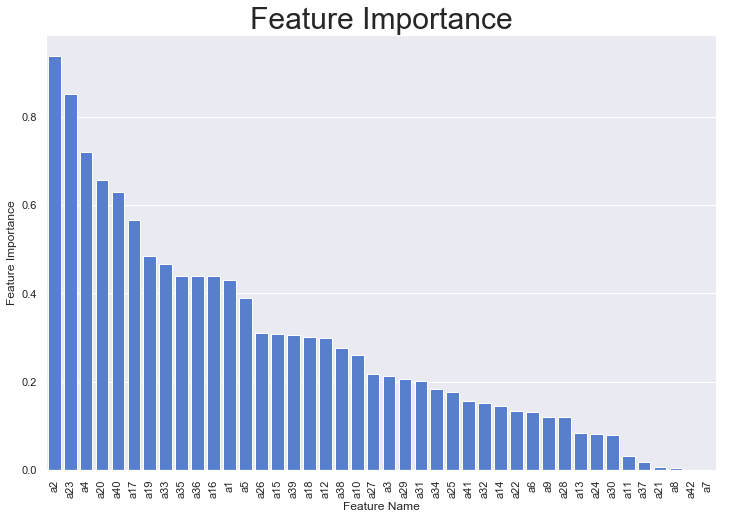

In [28]:
query = """
    SELECT unnest(string_to_array(independent_varnames,',')) AS feature_name
          ,unnest(impurity_var_importance) AS impurity_feature_importance
          ,unnest(oob_var_importance) AS oob_feature_importance
    FROM rf_model1_group l
        ,rf_model1_summary r
    ORDER BY 2 DESC
"""

df = query_gpdb(query)
ipd.display(df.head(10))
bar_plot(df,"Feature Importance","feature_name",'Feature Name',"impurity_feature_importance","Feature Importance", "#4378E2")

<a id="rf_score_out_of_sample"></a>
#### Score Validation Data

https://madlib.apache.org/docs/latest/group__grp__random__forest.html

In [30]:
# Score out-of-sample
query = """
    DROP TABLE IF EXISTS rf_model1_scored;
    SELECT madlib.forest_predict('rf_model1',
                                 'training_data_sample1',
                                 'rf_model1_scored',
                                 'response');
                
    DROP TABLE IF EXISTS model_test_scored_tmp;
    CREATE TABLE model_test_scored_tmp AS
    SELECT *
    FROM rf_model1_scored
    JOIN training_data_sample1
    USING (__madlib_id__);
    DROP TABLE rf_model1_scored;
    ALTER TABLE model_test_scored_tmp RENAME TO rf_model1_scored;
    SELECT * FROM rf_model1_scored LIMIT 10;
    
"""
cur.execute(query)

In [35]:
%%sql
DROP TABLE IF EXISTS rf_model1_scored;
SELECT madlib.forest_predict('rf_model1',
                                 'training_data_sample1',
                                 'rf_model1_scored',
                                 'response');

Done.
1 rows affected.


forest_predict
""


In [36]:
%%sql
select * from rf_model1_scored order by __madlib_id__ limit 10;

10 rows affected.


__madlib_id__,estimated_y
1,class06
2,class06
3,class06
4,class06
5,class06
6,class06
7,class06
8,class06
9,class06
10,class06


In [38]:
%%sql
DROP TABLE IF EXISTS rf_model1_scored;
SELECT madlib.forest_predict('rf_model1',
                                 'training_data_sample1',
                                 'rf_model1_scored',
                                 'response');
                
DROP TABLE IF EXISTS model_test_scored_tmp;
CREATE TABLE model_test_scored_tmp AS
SELECT *
FROM rf_model1_scored
JOIN training_data_sample1
USING (__madlib_id__);

select __madlib_id__, estimated_y, y from model_test_scored_tmp order by __madlib_id__ limit 10;

Done.
1 rows affected.
Done.
2300 rows affected.
10 rows affected.


__madlib_id__,estimated_y,y
1,class06,class06
2,class06,class06
3,class06,class06
4,class06,class06
5,class06,class06
6,class06,class06
7,class06,class06
8,class06,class06
9,class06,class06
10,class06,class06


In [41]:
%%sql
create table training_data1 as
  select row_number() over () as __madlib_id__ ,* from training_data;

4898431 rows affected.


[]

In [42]:
%%sql
select * from training_data1 limit 10;

10 rows affected.


__madlib_id__,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25,a26,a27,a28,a29,a30,a31,a32,a33,a34,a35,a36,a37,a38,a39,a40,a41,a42,y
2,ICMP,ECR_I,STAT10,1032.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,447.0,1.0,0.0,0.0,511.0,0.0,0.0,255.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0,class18
4,TCP,PRIVATE,STAT06,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.09,0,13.0,0.0,0.0,0.05,24.0,0.0,0.0,24.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.09,0.0,255.0,0.0,0.0,0.04,1.0,280.0,1.0,0,class10
6,TCP,PRIVATE,STAT06,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.02,0,13.0,0.0,0.0,0.07,2.0,0.0,0.0,2.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.01,0.0,255.0,0.0,0.0,0.07,1.0,122.0,1.0,0,class10
8,ICMP,ECR_I,STAT10,1032.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,571.0,1.0,0.0,0.0,511.0,0.0,0.0,255.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0,class18
10,ICMP,ECR_I,STAT10,1032.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,1361.0,1.0,0.0,0.0,511.0,0.0,0.0,255.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0,class18
12,TCP,HTTP,STAT10,312.0,607.0,0,0,0,0,1,0,0.0,0.0,1.0,0,1148.0,0.01,0.0,0.0,31.0,0.0,0.0,255.0,0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0,1.0,0.0,86.0,0.0,0.0,0.0,0.0,31.0,0.0,0,normal
14,ICMP,ECR_I,STAT10,1032.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,1052.0,1.0,0.0,0.0,511.0,0.0,0.0,255.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0,class18
16,ICMP,ECR_I,STAT10,1032.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,1623.0,1.0,0.0,0.0,511.0,0.0,0.0,255.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0,class18
18,TCP,HTTP,STAT10,301.0,1380.0,0,0,0,0,1,0,0.0,0.0,1.0,0,1750.0,0.0,0.0,0.01,7.0,0.0,0.0,251.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.98,0.0,255.0,0.0,0.0,0.0,0.0,7.0,0.0,0,normal
20,ICMP,ECR_I,STAT10,1032.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,1144.0,1.0,0.0,0.0,510.0,0.0,0.0,255.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,510.0,0.0,0,class18


In [44]:
%%sql
DROP TABLE IF EXISTS rf_model1_scored;
SELECT madlib.forest_predict('rf_model1',
                                 'training_data1',
                                 'rf_model1_scored',
                                 'response');

Done.
1 rows affected.


forest_predict
""


In [20]:
%%sql
DROP TABLE IF EXISTS model_test_scored_tmp;
CREATE TABLE model_test_scored_tmp AS
SELECT *
FROM rf_model1_scored
JOIN training_data1
USING (__madlib_id__);

 * postgresql://gpadmin@localhost:8000/madlib
Done.
4898431 rows affected.


[]

In [21]:
%%sql
select __madlib_id__, estimated_y, y from model_test_scored_tmp order by __madlib_id__ limit 10;

 * postgresql://gpadmin@localhost:8000/madlib
10 rows affected.


__madlib_id__,estimated_y,y
1,class18,class18
2,class18,class18
3,class10,class10
4,class10,class10
5,normal,normal
6,class10,class10
7,normal,normal
8,class18,class18
9,normal,normal
10,class18,class18


In [38]:
%%sql DROP TABLE IF EXISTS accuracy_by_class;
CREATE TABLE accuracy_by_class AS
    SELECT y,correct, total,correct::FLOAT/total as accuracy
FROM (SELECT y, COUNT(*) AS correct FROM model_test_scored_tmp WHERE y=estimated_y GROUP BY y) c JOIN
     (SELECT y,count(*) AS total FROM model_test_scored_tmp GROUP BY y) t USING(y);
SELECT * FROM accuracy_by_class ORDER BY total DESC;

 * postgresql://gpadmin@localhost:8000/madlib
Done.
23 rows affected.
23 rows affected.


y,correct,total,accuracy
class18,2807827,2807886,0.999978987751
class10,1069537,1072017,0.99768660385
normal,823988,972781,0.84704368198
class17,15501,15892,0.975396425875
class06,12302,12481,0.985658200465
class15,10122,10413,0.972054163065
class11,1666,2316,0.719343696028
class01,2196,2203,0.996822514753
class21,1017,1020,0.997058823529
class20,973,979,0.993871297242


In [39]:
%sql SELECT AVG(accuracy) AS balanced_accuracy FROM accuracy_by_class;

 * postgresql://gpadmin@localhost:8000/madlib
1 rows affected.


balanced_accuracy
0.95115096328


<a id="rf_auc"></a>
#### Area Under ROC Curve

In [ ]:
# auc
query = """
    DROP TABLE IF EXISTS public.model_test_scored_auc;
    SELECT madlib.area_under_roc(
        'public.model_test_scored'
       ,'public.model_test_scored_auc'
       ,'estimated_prob_1'
       ,'approval'
    )
"""
cur.execute(query)

query = """
    SELECT * 
    FROM public.model_test_scored_auc;
"""
auc = query_gpdb(query)['area_under_roc'][0]

message = """-----\n **AUC =** {:0.5f}""".format(auc)
printmd(message)

<a id="rf_roc"></a>
#### Receiver Operating Characteristic Graph (ROC Curve)

In [ ]:
# roc
query = """
    DROP TABLE IF EXISTS public.model_test_scored_roc;
    SELECT madlib.binary_classifier( 
        'public.model_test_scored'
       ,'public.model_test_scored_roc'
       ,'estimated_prob_1'
       ,'approval'
    );
"""
cur.execute(query)

query = """
    SELECT threshold
          ,fpr
          ,tpr
    FROM public.model_test_scored_roc
    ORDER BY 1
"""
df = query_gpdb(query)

# roc curve
pylab.rcParams['figure.figsize'] = (8, 8)

plt.figure()
lw = 2
plt.plot(df['fpr'], df['tpr'], color='darkgreen', lw=lw, label='AUC {:0.2f}'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show();

<a id="rf_confusion_matrix"></a>
#### Confusion Matrix

In [ ]:
# confusion matrix (inclusive)
cutoff = 0.5

query = """
        SELECT approval AS obs
              ,CASE WHEN estimated_prob_1 >= {} THEN 1 ELSE 0 END AS pred
              ,count(*) AS num
        FROM public.model_test_scored
        GROUP BY 1,2
        ORDER BY 1,2
    """.format(cutoff)

query_gpdb(query)

<a id="rf_model_storage"></a>
#### Model Storage

In [ ]:
query = """
        DROP TABLE IF EXISTS public.my_models;
        CREATE TABLE public.my_models (
            gid integer[]
           ,sample_id integer[]
           ,tree madlib.bytea8[]
           ,created timestamp
           ,team text
           ,owner text
           ,description text
           ,model_type text
           ,model_params text
           ,current boolean
           ,model_id serial
        );
        
        INSERT INTO public.my_models (
            SELECT array_agg(gid) AS gid
                  ,array_agg(sample_id) AS sample_id
                  ,array_agg(tree) AS tree
                  ,now() AS created
                  ,'Pivotal Data Science Atlanta' AS team
                  ,'Jarrod Vawdrey' AS owner
                  ,'This is an example credit scoring model' AS description
                  ,'MADlib random forest' AS model_type
                  ,'{num_trees= ,num_random_features= ,importance= ,num_permutations= ,max_tree_depth= ,min_split= ,min_bucket= ,num_splits= }' AS model_params
                  ,True AS current
            FROM public.rf_model_output   
        );
        
        SELECT gid
              ,sample_id
              ,created
              ,team
              ,owner
              ,description
              ,model_type
              ,model_params
              ,current
        FROM public.my_models
    """

query_gpdb(query)

----
## Model Scoring

<a id="model_scoring_Example"></a>
#### Model Scoring Example

In [ ]:
query = """
    DROP TABLE IF EXISTS public.credit_application_summary;
    SELECT madlib.summary('public.credit_application_data','public.credit_application_summary');
    SELECT * FROM public.credit_application_summary;
"""
data_summary = query_gpdb(query)

featureNames = ['a2', 'a3', 'a8', 'a11', 'a14', 'a15', 'a1_a', 'a4_l', 'a4_u', 'a5_g', 'a5_gg', 'a6_aa', 'a6_c', 'a6_cc', 'a6_d', 'a6_e', 'a6_ff', 'a6_i', 'a6_j', 'a6_k', 'a6_m', 'a6_q', 'a6_r', 'a6_w', 'a7_bb', 'a7_dd', 'a7_ff', 'a7_h', 'a7_j', 'a7_n', 'a7_o', 'a7_v', 'a9_true', 'a10_true', 'a12_true', 'a13_g', 'a13_p']
    

def add_continuous_slider(n, default):
    tstr = "target_column == '{}'".format(n)
    minValue = math.floor(data_summary.query(tstr)['min'])
    minValueOrZero = min(0,float(minValue))
    maxValue = math.ceil(data_summary.query(tstr)['max'])
    return widgets.FloatSlider(
        value=default,
        min=minValueOrZero,
        max=maxValue,
        step=0.1,
        description="",
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
    )

def add_drop_down(n, default):
    
    query = """
        SELECT {} AS col
        FROM public.credit_application_data
        GROUP BY 1
        ORDER BY 1
    """.format(n)
    values = query_gpdb(query)['col']

    return widgets.Dropdown(
        options=values,
        value=default,
        description='',
        disabled=False,
    )

def add_widgets():
    
    message = "### Loan Application \n ------"
    printmd(message)
    
    myWidgets = []

    myWidgets.append({'a1':add_drop_down('a1','a')})
    myWidgets.append({'a2':add_continuous_slider('a2',35.43)})
    myWidgets.append({'a3':add_continuous_slider('a3',12.0)})
    myWidgets.append({'a4':add_drop_down('a4','u')})
    myWidgets.append({'a5':add_drop_down('a5','g')})
    myWidgets.append({'a6':add_drop_down('a6','q')})
    myWidgets.append({'a7':add_drop_down('a7','h')})
    myWidgets.append({'a8':add_continuous_slider('a8',14.0)})
    myWidgets.append({'a9':add_drop_down('a9',True)})
    myWidgets.append({'a10':add_drop_down('a10',True)})
    myWidgets.append({'a11':add_continuous_slider('a11',8.0)})
    myWidgets.append({'a12':add_drop_down('a12',False)})
    myWidgets.append({'a13':add_drop_down('a13','g')})
    myWidgets.append({'a14':add_continuous_slider('a14',0.0)})
    myWidgets.append({'a15':add_continuous_slider('a15',6590.0)})
    
    for widget in myWidgets:
        n = widget.keys()[0]
        printmd("**{}:**".format(n))
        ipd.display(widget[n])

    message = "------"
    printmd(message)
    
    return myWidgets

    
def create_model_input(myWidgets):

    checks = {}
    conts = []
    f = []
    
    for i in range(0,len(featureNames)):
        f.append(0.0)
    
    for feature in featureNames:
        if "_" in feature:
            key = feature[0:feature.find("_")]
            val = feature[feature.find("_")+1:len(feature)]
            if key in checks:
                checks[key].append(val)
            else:
                checks[key] = [val]
        else:
            conts.append(feature)
            
    for widget in myWidgets:
        n = widget.keys()[0]
        val = widget[n].value

        # lower case boolean strings
        if isinstance(val,np.bool_):
            val = str(val).lower()

        if n in checks:
            checkFlag = False
            for c in checks[n]:
                if c == val:
                    checkFlag = True
                    pos = featureNames.index("{}_{}".format(n,val))
                    f[pos] = 1.0   
                    
            # make all associated values 0
            if checkFlag == False:
                for feature in featureNames:
                    if "_" in feature and feature[0:feature.find("_")+1] == n:
                        pos = featureNames.index(feature)
                        f[pos] = 0.0   
        elif n in conts:
            pos = featureNames.index(n)
            f[pos] = val

    return f
        
def rf_score(modelInputs):
    
    print(modelInputs)
    print(featureNames)
    
    ddlString = "_id integer"
    for f in featureNames:
        ddlString = ddlString + ",{} float".format(f)

    query = """
        DROP TABLE IF EXISTS public.prod_example_data, public.prod_example_score;
        CREATE TABLE public.prod_example_data ({});
        INSERT INTO public.prod_example_data VALUES ({});
        DROP TABLE IF EXISTS public.model_test_scored_tmp;
        SELECT madlib.forest_predict('public.rf_model_output',
                                     'public.prod_example_data',
                                     'public.prod_example_score',
                                     'prob');
        SELECT * FROM public.prod_example_score;
    """.format(ddlString, ",".join(str(x) for x in modelInputs))

    score = float(query_gpdb(query)['estimated_prob_1'])
    
    message = "High"
    if score <= 0.5:
        message = "Low"
    elif score <= 0.75:
        message = "Average"
    
    return (score, message)
    
def on_appbutton_click(b):
    
    ipd.clear_output()
    
    message = "### Loan Approval Results \n------\n"
    printmd(message)
    
    modelInput = create_model_input(myWidgets)
    
    s, m = rf_score(modelInput)
    
    message = "**Approval Score:** {}".format(s)
    printmd(message)
    
    message = "*Your chances of being approved are '{}'*".format(m)
    printmd(message)
    
    cleanModelInputs = ""
    for i in range(0,len(featureNames)):
        cleanModelInputs = cleanModelInputs + "{} = {}\n\n".format(featureNames[i],modelInput[i])

    message = "**Model Inputs:** \n\n{}".format(cleanModelInputs)
    printmd(message)
    
    printmd("\n------")
    
myWidgets = add_widgets()
appbutton = widgets.Button(description="Calculate Approval")
ipd.display(appbutton)
appbutton.on_click(on_appbutton_click)
